# Gap Overlap Eye-Tracking Data Pre-processing

This notebook performs comprehensive pre-processing of eye-tracking data from the Gap Overlap task, including:
- Trial validity assessment
- Participant exclusion criteria
- Eye-tracker calibration quality analysis
- Demographic summaries of excluded participants

In [188]:
import pandas as pd
from pathlib import Path
import numpy as np
import time
import os
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy import stats
import pingouin as pg
import scikit_posthocs as sp
import statsmodels.api as sm
from scipy.stats import boxcox
from statannotations.Annotator import Annotator
from scipy.stats import pearsonr
import docx
from docx.enum.section import WD_ORIENT
from docx.enum.section import WD_SECTION
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.shared import Pt
from statsmodels.stats.outliers_influence import variance_inflation_factor

import mne
from mne.datasets.eyelink import data_path
from mne.preprocessing.eyetracking import read_eyelink_calibration
from mne.viz.eyetracking import plot_gaze

from eyelinkio import read_edf
from tqdm import tqdm




In [189]:
# Date 
date ="2025_06_27"

## Configuration Parameters

Set the key parameters for preprocessing analysis.

In [190]:
# Papermill parameters
date = "2025_06_27"
min_n_trials_per_condition = 6
full_preprocessing = False
run_test = True

In [191]:

def df_to_table(doc, df):
    # Add a table to the end and create a reference variable
    t = doc.add_table(df.shape[0]+1, df.shape[1])

    # Make sure df is rounded 
    df = df.round(2)

    # Make sure table is auto fit
    for cell in t._cells:
        cell.width = docx.shared.Inches(1.0)
    
    # Set the style of the table
    table_style = doc.styles['Table Grid']

    # Add the header rows.
    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    # Add the rest of the data frame
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    
    return doc


## Create Word Document for Preprocessing Results

This section initializes a Word document to capture all preprocessing results and statistics.

In [192]:

# Create a document

doc = docx.Document()

# Title page
section = doc.sections[0]
#section.start_type = WD_SECTION.ODD_PAGE
#section.orientation = WD_ORIENT.LANDSCAPE
#section.page_width, section.page_height = section.page_height, section.page_width
doc.add_heading('Q1K Gap Task - Eye Tracking Preprocessing', 0)
# Add new doc section with landscape orientation
section = doc.add_section()
section.start_type = WD_SECTION.ODD_PAGE
new_width, new_height = section.page_height, section.page_width
section.orientation = WD_ORIENT.LANDSCAPE
section.page_width = new_width


doc.add_heading(f"Data pre-processings results", 0)

doc.add_heading('Invalid Trial Criteria', level=1)
doc.add_paragraph(
    "A trial is considered invalid if it meets any of the following criteria:\n\n"
    "1. Did not look at fixation point for at least 500 ms\n"
    "   - The participant was distracted at the beginning of the trial and failed to maintain gaze on the fixation point for the required duration.\n\n"
    "2. Reaction time (RT) to peripheral target is greater than 1200 ms\n"
    "   - The participant took too long to respond, indicating possible distraction or inattention.\n\n"
    "3. Reaction time (RT) is less than 100 ms\n"
    "   - Extremely fast responses are likely anticipatory and not genuine reactions.\n\n"
    "4. Gaze directed to the wrong side of the screen\n"
    "   - The participant looked away from the intended target, indicating an incorrect response.\n\n"
    "5. Minimum number of trials\n"
    "   - The participant must have a minimum of 6 valid trials per condition in order to not be removed.\n\n"
    "Note:\n"
    "These criteria help ensure that only valid, attentive, and accurate trials are included in the analysis. "
    "Excluding invalid trials improves the reliability of behavioral and statistical results. "
    "Trial exclusion is automatically done by SR Research code and thus, invalid trials are coded into .txt files"
)


## Data loading

In [194]:
# Load et file
go_df= pd.read_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/gap/extraction/go_df_extraction.csv")
go_df        

,subject,trial_index,condition,side,rt,valid_trials,eeg_age,site,sex,asd,ndd,q1k_ID,group,age_group
0,002Z,1,Baseline,Right,230.31,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult
1,002Z,2,Gap,Right,255.00,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult
2,002Z,3,Overlap,Left,323.78,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult
3,002Z,4,Gap,Right,197.00,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult
4,002Z,5,Baseline,Left,372.62,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8249,1256S2,34,Overlap,Right,368.29,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult
8250,1256S2,35,Gap,Left,247.00,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult
8251,1256S2,36,Baseline,Right,211.76,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult
8252,1256S2,37,Overlap,Right,319.85,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult


In [195]:
# Load subjects removed file
subjects_removed_df = pd.read_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/missingness/subjects_removed.csv")
subjects_removed_df

,subject,status
0,004_Z,empty file
1,0105F1,empty file
2,1006P,empty file
3,1021F1,empty file
4,1045F1,empty file
5,1052P,empty file
6,1057F1,empty file
7,1089M1,empty file
8,1143S1,empty file
9,1147S2,empty file


In [196]:
# Print totl number of subjects and removed subjects
print(f"Total number of subjects: {len(go_df['subject'].unique())}")
print(f"Number of subjects removed: {len(subjects_removed_df['subject'].unique())}")

Total number of subjects: 230
Number of subjects removed: 13


## Calculate valid and invalid trials

## Invalid Trial Criteria

A trial is considered **invalid** if it meets any of the following criteria:

1. **Did not look at fixation point for at least 500 ms**  
   - The participant was distracted at the beginning of the trial and failed to maintain gaze on the fixation point for the required duration.

2. **Reaction time (RT) to peripheral target is greater than 1200 ms**  
   - The participant took too long to respond, indicating possible distraction or inattention.

3. **Reaction time (RT) is less than 100 ms**  
   - Extremely fast responses are likely anticipatory and not genuine reactions.

4. **Gaze directed to the wrong side of the screen**  
   - The participant looked away from the intended target, indicating an incorrect response.

5. **Minimum number of trials**
   - The participant must have a minimum of 6 valid trials per condition in order to not be removed

> **Note:**  
> These criteria help ensure that only valid, attentive, and accurate trials are included in the analysis. Excluding invalid trials improves the reliability of behavioral and statistical results. Trial exclusion is automatically done by SR Research code and thus, invalid trials are coded into .txt files


### Remove Trials with Negative Reaction Times

Trials with negative reaction times are considered invalid and will be excluded from analysis.

In [197]:
# Change reaction times below 0 to invalid trials 

# Print total number of trials that were removed
print(f"Total number of trials with negative RT: {len(go_df[go_df.rt < 0])}")
go_df.loc[go_df.rt < 0, "valid_trials"] = False

# Print total trials above 1200ms
print(f"Total number of trials with RT above 1200ms: {len(go_df[go_df.rt > 1200])}")

# Convert invalid trial's rt into np.nan values
go_df.loc[go_df.valid_trials == False, "rt"] = np.nan

Total number of trials with negative RT: 725
Total number of trials with RT above 1200ms: 186


### Additional Quality Checks

Perform additional quality checks on reaction time data.

In [198]:
# Check for extremely slow or fast reaction times beyond the initial criteria
print("REACTION TIME QUALITY CHECKS")

# Check for trials with RT between 0-100ms (anticipatory responses)
anticipatory_trials = go_df[(go_df.rt < 0) & (go_df.rt < 100) & (go_df.valid_trials == True)]
print(f"Trials with anticipatory RT (0-100ms): {len(anticipatory_trials)}")

# Mark anticipatory trials as invalid
if len(anticipatory_trials) > 0:
    go_df.loc[(go_df.rt < 0) & (go_df.rt < 100), "valid_trials"] = False
    go_df.loc[(go_df.rt < 0) & (go_df.rt < 100), "rt"] = np.nan
    print("Anticipatory trials marked as invalid")

# Check for extremely slow responses (> 1200ms)
slow_trials = go_df[(go_df.rt > 1200) & (go_df.valid_trials == True)]
print(f"Trials with slow RT (>1200ms): {len(slow_trials)}")

# Mark slow trials as invalid
if len(slow_trials) > 0:
    go_df.loc[go_df.rt > 1200, "valid_trials"] = False
    go_df.loc[go_df.rt > 1200, "rt"] = np.nan
    print("Slow trials marked as invalid")



REACTION TIME QUALITY CHECKS
Trials with anticipatory RT (0-100ms): 0
Trials with slow RT (>1200ms): 0


### Participant Statistics for Trial Validity

Calculate trial validity statistics for each participant across all conditions.

In [199]:
# Calculate the overall number of trials and failed trials per subject into one dataframe
total_trials = go_df.groupby(["subject", "ndd"]).size().reset_index(name="total_trials")
failed_trials = go_df[go_df.valid_trials == False].groupby(["subject"]).size().reset_index(name="failed_trials")

# Calculate the number of failed "Overlap" trials
total_overlap = go_df[go_df.condition == "Overlap"].groupby(["subject"]).size().reset_index(name="total_overlap")
failed_overlap = go_df[(go_df.valid_trials == False) & (go_df.condition == "Overlap")].groupby(["subject"]).size().reset_index(name="failed_overlap")

# Calculate the number of failed "Baseline" trials
total_baseline = go_df[go_df.condition == "Baseline"].groupby(["subject"]).size().reset_index(name="total_baseline")
failed_baseline = go_df[(go_df.valid_trials == False) & (go_df.condition == "Baseline")].groupby(["subject"]).size().reset_index(name="failed_baseline")

# Calculate the number of failed "Gap" trials
total_gap = go_df[go_df.condition == "Gap"].groupby(["subject"]).size().reset_index(name="total_gap")
failed_gap = go_df[(go_df.valid_trials == False) & (go_df.condition == "Gap")].groupby(["subject"]).size().reset_index(name="failed_gap")

# Merge all dataframes
trial_data = pd.merge(total_trials, failed_trials, on="subject", how="left")
trial_data = pd.merge(trial_data, total_overlap, on="subject", how="left")
trial_data = pd.merge(trial_data, failed_overlap, on="subject", how="left")
trial_data = pd.merge(trial_data, total_baseline, on="subject", how="left")
trial_data = pd.merge(trial_data, failed_baseline, on="subject", how="left")
trial_data = pd.merge(trial_data, total_gap, on="subject", how="left")
trial_data = pd.merge(trial_data, failed_gap, on="subject", how="left")

# Fill NaN values with 0
trial_data = trial_data.fillna(0)

# Percentage of failed trials
trial_data["failed_trials"] = trial_data["failed_trials"].fillna(0)
trial_data["%_failed"] = trial_data["failed_trials"] / trial_data["total_trials"] * 100

# Percentage of failed "Baseline" trials
trial_data["%_baseline"] = trial_data["failed_baseline"] / trial_data["total_baseline"] * 100

# Percentage of failed "Overlap" trials
trial_data["%_overlap"] = trial_data["failed_overlap"] / trial_data["total_overlap"] * 100

# Percentage of failed "Gap" trials
trial_data["%_gap"] = trial_data["failed_gap"] / trial_data["total_gap"] * 100

# Total valid trials 
trial_data["valid_trials"] = trial_data["total_trials"] - trial_data["failed_trials"]

# Total valid Baseline trials
trial_data["valid_baseline"] = trial_data["total_baseline"] - trial_data["failed_baseline"]

# Total valid Overlap trials
trial_data["valid_overlap"] = trial_data["total_overlap"] - trial_data["failed_overlap"]

# Total valid Gap trials
trial_data["valid_gap"] = trial_data["total_gap"] - trial_data["failed_gap"]

# Create column to highlight participants who have at least minimum valid trials in all conditions
trial_data["valid_trials_all_conditions"] = (
    (trial_data["valid_baseline"] >= min_n_trials_per_condition) &
    (trial_data["valid_overlap"] >= min_n_trials_per_condition) &
    (trial_data["valid_gap"] >= min_n_trials_per_condition)
)

# Keep only important columns
trial_data = trial_data[["subject", "ndd", "total_trials", "failed_trials", "%_failed", "total_overlap", "%_overlap", "total_baseline", "%_baseline", "total_gap", "%_gap", 
"valid_trials", "valid_baseline", "valid_overlap", "valid_gap", "valid_trials_all_conditions"]]

In [200]:
trial_data

,subject,ndd,total_trials,failed_trials,%_failed,total_overlap,%_overlap,total_baseline,%_baseline,total_gap,%_gap,valid_trials,valid_baseline,valid_overlap,valid_gap,valid_trials_all_conditions
0,002Z,no_ndd,36,1.0,2.777778,12.0,8.333333,12.0,0.000000,12.0,0.000000,35.0,12.0,11.0,12.0,True
1,0042P,ndd,36,1.0,2.777778,12.0,0.000000,12.0,8.333333,12.0,0.000000,35.0,11.0,12.0,12.0,True
2,0043F1,no_ndd,36,0.0,0.000000,12.0,0.000000,12.0,0.000000,12.0,0.000000,36.0,12.0,12.0,12.0,True
3,0050M1,no_ndd,36,1.0,2.777778,12.0,8.333333,12.0,0.000000,12.0,0.000000,35.0,12.0,11.0,12.0,True
4,0050P,ndd,44,11.0,25.000000,12.0,8.333333,16.0,31.250000,16.0,31.250000,33.0,11.0,11.0,11.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,1226P,ndd,30,15.0,50.000000,12.0,66.666667,4.0,25.000000,14.0,42.857143,15.0,3.0,4.0,8.0,False
226,1256F1,ndd,38,3.0,7.894737,12.0,0.000000,14.0,14.285714,12.0,8.333333,35.0,12.0,12.0,11.0,True
227,1256P,ndd,39,10.0,25.641026,13.0,46.153846,12.0,0.000000,14.0,28.571429,29.0,12.0,7.0,10.0,True
228,1256S1,ndd,36,1.0,2.777778,12.0,0.000000,12.0,8.333333,12.0,0.000000,35.0,11.0,12.0,12.0,True


In [201]:
# Add the trial data to the document
doc.add_heading('Valid Trial Analysis', level=1)

# Add bullet point for total number of participants 
doc.add_paragraph(f"Total number of participants: {len(trial_data['subject'].unique())}", style='ListBullet')

print(f"Total number of participants: {len(trial_data['subject'].unique())}")

# Add total number of participants with the min number of trials
doc.add_paragraph(f"Total number of participants with at least {min_n_trials_per_condition} valid trials in all conditions: {len(trial_data[trial_data['valid_trials_all_conditions'] == True])}", style='ListBullet')
print(f"Total number of participants with at least {min_n_trials_per_condition} valid trials in all conditions: {len(trial_data[trial_data['valid_trials_all_conditions'] == True])}")

Total number of participants: 230
Total number of participants with at least 6 valid trials in all conditions: 209


c:\Users\gabot\OneDrive - McGill University\Desktop\Github_repos\q1k_neurosubs\q1k_et_neurosubs_env\lib\site-packages\docx\styles\styles.py:125: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


In [202]:
# Add the subjects without min number of trial criteria to subjects_removed_df
missing_ids = trial_data[trial_data["valid_trials_all_conditions"] == False][["subject"]].copy()
# Add the subjects without min number of trial criteria to subjects_removed_df and add reasons as 'not enough trials'
missing_ids["status"] = f"not enough trials ({min_n_trials_per_condition})"
subjects_removed_df = pd.concat([subjects_removed_df, missing_ids], ignore_index=True)


In [203]:
subjects_removed_df

,subject,status
0,004_Z,empty file
1,0105F1,empty file
2,1006P,empty file
3,1021F1,empty file
4,1045F1,empty file
5,1052P,empty file
6,1057F1,empty file
7,1089M1,empty file
8,1143S1,empty file
9,1147S2,empty file


In [204]:
## Calculate and describe the properties of invalid trials
# Check the proportion of overlap, baseline and gap in the number of invalid trials
doc.add_heading('Proportion of Invalid Trials', level=1)
# Calculate the proportion of invalid trials for each condition
proportion_invalid = trial_data[["subject", "ndd", "%_overlap", "%_baseline", "%_gap"]].copy()

# Describe proportion_invalid by calculating the mean for only the dropped subjects
proportion_invalid = proportion_invalid[proportion_invalid["subject"].isin(subjects_removed_df["subject"])]

proportion_invalid = proportion_invalid.groupby("ndd").agg(
    mean_overlap=("%_overlap", "mean"),
    mean_baseline=("%_baseline", "mean"),
    mean_gap=("%_gap", "mean"),
).reset_index()
proportion_invalid = proportion_invalid.round(2)

# Add another column for the sum of total trials for each category only for those that were dropped
trial_data_dropped = trial_data[trial_data["subject"].isin(subjects_removed_df["subject"])]

proportion_invalid["sum_overlap"] = trial_data_dropped.groupby("ndd")["total_overlap"].sum().values
proportion_invalid["sum_baseline"] = trial_data_dropped.groupby("ndd")["total_baseline"].sum().values
proportion_invalid["sum_gap"] = trial_data_dropped.groupby("ndd")["total_gap"].sum().values

# Change column names to improve clarity
proportion_invalid.rename(
    columns={
        "ndd": "NDD Group",
        "mean_overlap": "Mean % Overlap Invalid Trials",
        "mean_baseline": "Mean % Baseline Invalid Trials",
        "mean_gap": "Mean % Gap Invalid Trials"
    },
    inplace=True,
)

# Add the proportion of invalid trials to the document
doc.add_heading('Description of Invalid Trial Data', level=3)
doc = df_to_table(doc, proportion_invalid)

proportion_invalid

,NDD Group,Mean % Overlap Invalid Trials,Mean % Baseline Invalid Trials,Mean % Gap Invalid Trials,sum_overlap,sum_baseline,sum_gap
0,ndd,62.02,57.12,67.99,107.0,111.0,119.0
1,no_ndd,69.05,57.56,52.95,34.0,60.0,38.0


### Check Participant's Eye-Tracker Calibration Quality

Analyze calibration quality for each participant to identify those with poor calibration that should be excluded from analysis.

In [205]:
# Process calibration data from EDF files using eyelinkio
calibration_data_edf = {}
missing_calibrations = []
edf_files = glob.glob("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files/edf_files/*.edf")

# Load calilbration quality data to filter out subjects already processed
calibration_processed = pd.read_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/missingness/calibration/calibration_quality.csv")

# Exclude subjects already processed, but only if not asked to do full proccessing
full_preprocessing = False  # Set to True if you want to process all EDF files

if not full_preprocessing:
    print(f"Excluding subjects already processed: {calibration_processed['subject'].values}")
    # Filter out EDF files for subjects already processed
    edf_files = [edf_file for edf_file in edf_files if edf_file.split("\\")[-1].split("_")[0] not in calibration_processed["subject"].values]
else: 
    print("Processing all EDF files, including those already processed.")
    
print(f"Number of EDF files to process: {len(edf_files)}")
for edf_file in tqdm(edf_files, desc="Processing EDF files"):
    subject_id = edf_file.split("\\")[-1].split("_")[0]
    print(f"Processing EDF file for subject: {subject_id}")
    
    # Read EDF file and extract calibration data
    try:
        edf_data = read_edf(edf_file)
        raw, calibrations = edf_data.to_mne()
    except Exception as e:
        print(f"  Error reading EDF file: {e}")
        missing_calibrations.append(subject_id)
        continue
        
    if len(calibrations) == 0:
        print(f"  No calibrations found - skipping")
        missing_calibrations.append(subject_id)
        
        continue
    
    # Use the last calibration
    last_cal = calibrations[-1]
    avg_error = last_cal["avg_error"]
    max_error = last_cal["max_error"]
    
    # Calculate trimmed mean
    trimmed_mean= stats.trim_mean(last_cal["offsets"], 0.25) 

    
    # Classify calibration quality
    if avg_error < 1.0 and max_error < 1.5:
        quality = "good"
    elif avg_error < 1.5 and max_error <= 2.0:
        quality = "fair"
    else:
        quality = "poor"
    
    # If the quality is poor, save a plot of the calibration but do not plot it here for memory efficiency
    if quality == "poor":
        # Save a plot of the calibration
        fig = calibrations[-1].plot(show=False)
        fig.suptitle(f"Calibration for {subject_id} - Quality: {quality}", fontsize=16)
        fig.savefig(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/figures/calibration/poor/{subject_id}_calibration.png")
        plt.close(fig)
               
    
    print(f"  EDF: {len(calibrations)} calibrations, avg_error={avg_error:.3f}°, max_error={max_error:.3f}°, quality={quality}")
    
    calibration_data_edf[subject_id] = {
        'n_calibrations': len(calibrations),
        'avg_error': avg_error,
        'max_error': max_error,
        'calibration_quality': quality, 
        'trimmed_mean': trimmed_mean
    }

# Convert to dataframe
calibration_df_edf = pd.DataFrame.from_dict(calibration_data_edf, orient="index").reset_index()
calibration_df_edf.rename(columns={"index": "subject"}, inplace=True)

print(f"\nEDF processing complete: {len(calibration_df_edf)} subjects processed")
calibration_df_edf.head()

# Merge with existing calibration quality data
if not full_preprocessing:
    # Load existing calibration quality data
    existing_calibration_df = pd.read_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/missingness/calibration/calibration_quality.csv")
    
    # Merge with new calibration data
    calibration_df = pd.concat([existing_calibration_df, calibration_df_edf], ignore_index=True)

Excluding subjects already processed: ['0042P' '0043F1' '0050M1' '0083F1' '0083M1' '0083P' '0050P' '0062P'
 '0064M1' '0064S1' '0068M1' '0068S3' '0086F1' '0086M1' '0086S1' '0093O1'
 '0104P' '0105P' '0111F1' '0111M1' '0119M1' '0128P' '0129M1' '0131M1'
 '0131P' '0131S1' '0134F1' '0134M1' '0134S1' '0146P' '0147F2' '0147M1'
 '0147P' '0150M1' '0152M1' '0157M1' '0159M1' '0162M1' '0162P' '0162S1'
 '0171F1' '0171M1' '0171P' '0179M1' '0179P' '0181F1' '0181M1' '0181P'
 '0183M1' '0183P' '0183S1' '0186F1' '0186M1' '0196M1' '0196P' '0196S2'
 '0200F1' '0200M1' '0200P' '0200S1' '0216M1' '0216P' '0218M1' '0218P'
 '0223M1' '0223P' '0223S2' '0248F1' '0248M1' '0248P' '0248S1' '0265M1'
 '0265P' '0275F1']
Number of EDF files to process: 141


Processing EDF files:   0%|          | 0/141 [00:00<?, ?it/s]

Processing EDF file for subject: 0068F1
Creating RawArray with float64 data, n_channels=3, n_times=126310
    Range : 0 ... 126309 =      0.000 ...   126.309 secs
Ready.


Processing EDF files:   1%|          | 1/141 [00:01<03:45,  1.61s/it]

  No calibrations found - skipping
Processing EDF file for subject: 0068S1
Creating RawArray with float64 data, n_channels=3, n_times=150293
    Range : 0 ... 150292 =      0.000 ...   150.292 secs
Ready.


Processing EDF files:   1%|▏         | 2/141 [00:03<03:53,  1.68s/it]

  No calibrations found - skipping
Processing EDF file for subject: 0105F1
  Error reading EDF file: 'sample_fields'
Processing EDF file for subject: 0275P
Creating RawArray with float64 data, n_channels=3, n_times=77914
    Range : 0 ... 77913 =      0.000 ...   155.826 secs
Ready.


Processing EDF files:   3%|▎         | 4/141 [00:04<02:07,  1.08it/s]

  EDF: 2 calibrations, avg_error=0.750°, max_error=1.020°, quality=good
Processing EDF file for subject: 0281M1
Creating RawArray with float64 data, n_channels=3, n_times=61692
    Range : 0 ... 61691 =      0.000 ...   123.382 secs
Ready.


Processing EDF files:   4%|▎         | 5/141 [00:05<02:00,  1.13it/s]

  EDF: 1 calibrations, avg_error=0.200°, max_error=0.390°, quality=good
Processing EDF file for subject: 0281P
Creating RawArray with float64 data, n_channels=3, n_times=64199
    Range : 0 ... 64198 =      0.000 ...   128.396 secs
Ready.


Processing EDF files:   4%|▍         | 6/141 [00:05<01:55,  1.17it/s]

  EDF: 1 calibrations, avg_error=0.420°, max_error=0.720°, quality=good
Processing EDF file for subject: 0286F1
Creating RawArray with float64 data, n_channels=3, n_times=64869
    Range : 0 ... 64868 =      0.000 ...   129.736 secs
Ready.


Processing EDF files:   5%|▍         | 7/141 [00:06<01:51,  1.20it/s]

  EDF: 1 calibrations, avg_error=0.122°, max_error=0.250°, quality=good
Processing EDF file for subject: 0286S1
Creating RawArray with float64 data, n_channels=3, n_times=64897
    Range : 0 ... 64896 =      0.000 ...   129.792 secs
Ready.


Processing EDF files:   6%|▌         | 8/141 [00:07<01:48,  1.22it/s]

  EDF: 1 calibrations, avg_error=0.278°, max_error=0.550°, quality=good
Processing EDF file for subject: 0296F1
Creating RawArray with float64 data, n_channels=3, n_times=64607
    Range : 0 ... 64606 =      0.000 ...   129.212 secs
Ready.


Processing EDF files:   6%|▋         | 9/141 [00:08<01:48,  1.22it/s]

  EDF: 2 calibrations, avg_error=1.076°, max_error=1.720°, quality=fair
Processing EDF file for subject: 0296M1
Creating RawArray with float64 data, n_channels=3, n_times=65453
    Range : 0 ... 65452 =      0.000 ...   130.904 secs
Ready.


Processing EDF files:   7%|▋         | 10/141 [00:09<01:49,  1.20it/s]

  EDF: 1 calibrations, avg_error=0.276°, max_error=0.520°, quality=good
Processing EDF file for subject: 0296P
Creating RawArray with float64 data, n_channels=3, n_times=80335
    Range : 0 ... 80334 =      0.000 ...   160.668 secs
Ready.


Processing EDF files:   8%|▊         | 11/141 [00:10<01:55,  1.12it/s]

  EDF: 4 calibrations, avg_error=0.802°, max_error=1.640°, quality=fair
Processing EDF file for subject: 0296S1
Creating RawArray with float64 data, n_channels=3, n_times=61653
    Range : 0 ... 61652 =      0.000 ...   123.304 secs
Ready.


Processing EDF files:   9%|▊         | 12/141 [00:11<01:54,  1.12it/s]

  EDF: 1 calibrations, avg_error=0.336°, max_error=0.710°, quality=good
Processing EDF file for subject: 0315M1
Creating RawArray with float64 data, n_channels=3, n_times=62341
    Range : 0 ... 62340 =      0.000 ...   124.680 secs
Ready.


Processing EDF files:   9%|▉         | 13/141 [00:11<01:55,  1.11it/s]

  EDF: 1 calibrations, avg_error=0.594°, max_error=0.920°, quality=good
Processing EDF file for subject: 0315P
Creating RawArray with float64 data, n_channels=3, n_times=61803
    Range : 0 ... 61802 =      0.000 ...   123.604 secs
Ready.


Processing EDF files:  10%|▉         | 14/141 [00:12<01:51,  1.14it/s]

  EDF: 3 calibrations, avg_error=0.706°, max_error=1.000°, quality=good
Processing EDF file for subject: 1006M1
Creating RawArray with float64 data, n_channels=3, n_times=60834
    Range : 0 ... 60833 =      0.000 ...   121.666 secs
Ready.


Processing EDF files:  11%|█         | 15/141 [00:13<01:54,  1.10it/s]

  EDF: 1 calibrations, avg_error=1.270°, max_error=4.510°, quality=poor
Processing EDF file for subject: 1009M1
Creating RawArray with float64 data, n_channels=3, n_times=65875
    Range : 0 ... 65874 =      0.000 ...   131.748 secs
Ready.


Processing EDF files:  11%|█▏        | 16/141 [00:14<01:50,  1.13it/s]

  EDF: 1 calibrations, avg_error=0.418°, max_error=0.750°, quality=good
Processing EDF file for subject: 1009P
Creating RawArray with float64 data, n_channels=3, n_times=61709
    Range : 0 ... 61708 =      0.000 ...   123.416 secs
Ready.


Processing EDF files:  12%|█▏        | 17/141 [00:15<01:47,  1.16it/s]

  EDF: 1 calibrations, avg_error=0.440°, max_error=0.700°, quality=good
Processing EDF file for subject: 1009S1
Creating RawArray with float64 data, n_channels=3, n_times=58860
    Range : 0 ... 58859 =      0.000 ...   117.718 secs
Ready.


Processing EDF files:  13%|█▎        | 18/141 [00:16<01:41,  1.21it/s]

  EDF: 1 calibrations, avg_error=0.374°, max_error=0.800°, quality=good
Processing EDF file for subject: 1021F1
  Error reading EDF file: 'sample_fields'
Processing EDF file for subject: 1024M1
Creating RawArray with float64 data, n_channels=3, n_times=60811
    Range : 0 ... 60810 =      0.000 ...   121.620 secs
Ready.


Processing EDF files:  14%|█▍        | 20/141 [00:16<01:15,  1.60it/s]

  EDF: 1 calibrations, avg_error=0.208°, max_error=0.330°, quality=good
Processing EDF file for subject: 1024P
Creating RawArray with float64 data, n_channels=3, n_times=62174
    Range : 0 ... 62173 =      0.000 ...   124.346 secs
Ready.


Processing EDF files:  15%|█▍        | 21/141 [00:17<01:22,  1.45it/s]

  EDF: 2 calibrations, avg_error=0.654°, max_error=1.020°, quality=good
Processing EDF file for subject: 1026M1
Creating RawArray with float64 data, n_channels=3, n_times=65995
    Range : 0 ... 65994 =      0.000 ...   131.988 secs
Ready.


Processing EDF files:  16%|█▌        | 22/141 [00:18<01:28,  1.34it/s]

  EDF: 3 calibrations, avg_error=0.808°, max_error=1.350°, quality=good
Processing EDF file for subject: 1026P
Creating RawArray with float64 data, n_channels=3, n_times=65984
    Range : 0 ... 65983 =      0.000 ...   131.966 secs
Ready.
  EDF: 2 calibrations, avg_error=0.390°, max_error=0.720°, quality=good

Processing EDF files:  16%|█▋        | 23/141 [00:19<01:39,  1.18it/s]


Processing EDF file for subject: 1028P
Creating RawArray with float64 data, n_channels=3, n_times=3884
    Range : 0 ... 3883 =      0.000 ...     7.766 secs
Ready.
  No calibrations found - skipping
Processing EDF file for subject: 1028S1
Creating RawArray with float64 data, n_channels=3, n_times=59483
    Range : 0 ... 59482 =      0.000 ...   118.964 secs
Ready.


Processing EDF files:  18%|█▊        | 25/141 [00:20<01:21,  1.43it/s]

  EDF: 1 calibrations, avg_error=0.254°, max_error=0.360°, quality=good
Processing EDF file for subject: 1028S2
Creating RawArray with float64 data, n_channels=3, n_times=66992
    Range : 0 ... 66991 =      0.000 ...   133.982 secs
Ready.


Processing EDF files:  18%|█▊        | 26/141 [00:21<01:24,  1.36it/s]

  EDF: 1 calibrations, avg_error=0.244°, max_error=0.550°, quality=good
Processing EDF file for subject: 1033M1
Creating RawArray with float64 data, n_channels=3, n_times=60782
    Range : 0 ... 60781 =      0.000 ...   121.562 secs
Ready.


Processing EDF files:  19%|█▉        | 27/141 [00:22<01:26,  1.32it/s]

  EDF: 1 calibrations, avg_error=0.376°, max_error=0.750°, quality=good
Processing EDF file for subject: 1033P
Creating RawArray with float64 data, n_channels=3, n_times=66744
    Range : 0 ... 66743 =      0.000 ...   133.486 secs
Ready.


Processing EDF files:  20%|█▉        | 28/141 [00:23<01:31,  1.23it/s]

  EDF: 1 calibrations, avg_error=0.460°, max_error=0.980°, quality=good
Processing EDF file for subject: 1033S1
Creating RawArray with float64 data, n_channels=3, n_times=60141
    Range : 0 ... 60140 =      0.000 ...   120.280 secs
Ready.


Processing EDF files:  21%|██        | 29/141 [00:24<01:30,  1.23it/s]

  EDF: 1 calibrations, avg_error=0.360°, max_error=0.690°, quality=good
Processing EDF file for subject: 1037F1
Creating RawArray with float64 data, n_channels=3, n_times=65249
    Range : 0 ... 65248 =      0.000 ...   130.496 secs
Ready.


Processing EDF files:  21%|██▏       | 30/141 [00:25<01:34,  1.18it/s]

  EDF: 1 calibrations, avg_error=0.354°, max_error=0.610°, quality=good
Processing EDF file for subject: 1037P
Creating RawArray with float64 data, n_channels=3, n_times=4058
    Range : 0 ... 4057 =      0.000 ...     8.114 secs
Ready.


Processing EDF files:  22%|██▏       | 31/141 [00:25<01:15,  1.46it/s]

  EDF: 1 calibrations, avg_error=19.980°, max_error=33.870°, quality=poor
Processing EDF file for subject: 1040M1
Creating RawArray with float64 data, n_channels=3, n_times=64353
    Range : 0 ... 64352 =      0.000 ...   128.704 secs
Ready.


Processing EDF files:  23%|██▎       | 32/141 [00:26<01:23,  1.31it/s]

  EDF: 1 calibrations, avg_error=0.334°, max_error=0.610°, quality=good
Processing EDF file for subject: 1040P
Creating RawArray with float64 data, n_channels=3, n_times=84666
    Range : 0 ... 84665 =      0.000 ...   169.330 secs
Ready.


Processing EDF files:  23%|██▎       | 33/141 [00:28<01:56,  1.08s/it]

  EDF: 1 calibrations, avg_error=0.312°, max_error=0.410°, quality=good
Processing EDF file for subject: 1042F1
Creating RawArray with float64 data, n_channels=3, n_times=60077
    Range : 0 ... 60076 =      0.000 ...   120.152 secs
Ready.


Processing EDF files:  24%|██▍       | 34/141 [00:29<02:09,  1.21s/it]

  EDF: 1 calibrations, avg_error=0.346°, max_error=0.480°, quality=good
Processing EDF file for subject: 1042M1
Creating RawArray with float64 data, n_channels=3, n_times=74519
    Range : 0 ... 74518 =      0.000 ...   149.036 secs
Ready.


Processing EDF files:  25%|██▍       | 35/141 [00:30<02:04,  1.18s/it]

  EDF: 2 calibrations, avg_error=0.584°, max_error=1.260°, quality=good
Processing EDF file for subject: 1042P
Creating RawArray with float64 data, n_channels=3, n_times=65603
    Range : 0 ... 65602 =      0.000 ...   131.204 secs
Ready.


Processing EDF files:  26%|██▌       | 36/141 [00:31<01:54,  1.09s/it]

  EDF: 1 calibrations, avg_error=0.220°, max_error=0.410°, quality=good
Processing EDF file for subject: 1045F1
  Error reading EDF file: 'sample_fields'
Processing EDF file for subject: 1045P
Creating RawArray with float64 data, n_channels=3, n_times=59149
    Range : 0 ... 59148 =      0.000 ...   118.296 secs
Ready.


Processing EDF files:  27%|██▋       | 38/141 [00:32<01:18,  1.31it/s]

  EDF: 1 calibrations, avg_error=0.480°, max_error=0.830°, quality=good
Processing EDF file for subject: 1045S1
Creating RawArray with float64 data, n_channels=3, n_times=61203
    Range : 0 ... 61202 =      0.000 ...   122.404 secs
Ready.


Processing EDF files:  28%|██▊       | 39/141 [00:33<01:19,  1.28it/s]

  EDF: 1 calibrations, avg_error=0.700°, max_error=1.140°, quality=good
Processing EDF file for subject: 1052F1
Creating RawArray with float64 data, n_channels=3, n_times=62891
    Range : 0 ... 62890 =      0.000 ...   125.780 secs
Ready.
  EDF: 1 calibrations, avg_error=1.778°, max_error=4.370°, quality=poor


Processing EDF files:  28%|██▊       | 40/141 [00:34<01:24,  1.20it/s]

Processing EDF file for subject: 1052M1
Creating RawArray with float64 data, n_channels=3, n_times=59294
    Range : 0 ... 59293 =      0.000 ...   118.586 secs
Ready.


Processing EDF files:  29%|██▉       | 41/141 [00:35<01:21,  1.22it/s]

  EDF: 1 calibrations, avg_error=0.556°, max_error=0.980°, quality=good
Processing EDF file for subject: 1052P
  Error reading EDF file: 'sample_fields'
Processing EDF file for subject: 1052S1
Creating RawArray with float64 data, n_channels=3, n_times=61332
    Range : 0 ... 61331 =      0.000 ...   122.662 secs
Ready.


Processing EDF files:  30%|███       | 43/141 [00:36<01:06,  1.47it/s]

  EDF: 1 calibrations, avg_error=0.504°, max_error=0.900°, quality=good
Processing EDF file for subject: 1057F1
  Error reading EDF file: 'sample_fields'
Processing EDF file for subject: 1057M1
Creating RawArray with float64 data, n_channels=3, n_times=62523
    Range : 0 ... 62522 =      0.000 ...   125.044 secs
Ready.


Processing EDF files:  32%|███▏      | 45/141 [00:37<00:58,  1.64it/s]

  EDF: 1 calibrations, avg_error=0.716°, max_error=1.260°, quality=good
Processing EDF file for subject: 1057P
Creating RawArray with float64 data, n_channels=3, n_times=17430
    Range : 0 ... 17429 =      0.000 ...    34.858 secs
Ready.


Processing EDF files:  33%|███▎      | 46/141 [00:37<00:54,  1.74it/s]

  EDF: 2 calibrations, avg_error=2.824°, max_error=11.010°, quality=poor
Processing EDF file for subject: 1061F1
Creating RawArray with float64 data, n_channels=3, n_times=61461
    Range : 0 ... 61460 =      0.000 ...   122.920 secs
Ready.


Processing EDF files:  33%|███▎      | 47/141 [00:38<01:00,  1.56it/s]

  EDF: 1 calibrations, avg_error=0.770°, max_error=1.530°, quality=fair
Processing EDF file for subject: 1061M1
Creating RawArray with float64 data, n_channels=3, n_times=66607
    Range : 0 ... 66606 =      0.000 ...   133.212 secs
Ready.


Processing EDF files:  34%|███▍      | 48/141 [00:39<01:07,  1.38it/s]

  EDF: 1 calibrations, avg_error=0.526°, max_error=0.770°, quality=good
Processing EDF file for subject: 1061S3
Creating RawArray with float64 data, n_channels=3, n_times=71418
    Range : 0 ... 71417 =      0.000 ...   142.834 secs
Ready.


Processing EDF files:  35%|███▍      | 49/141 [00:40<01:13,  1.25it/s]

  EDF: 1 calibrations, avg_error=0.408°, max_error=0.610°, quality=good
Processing EDF file for subject: 1067M1
Creating RawArray with float64 data, n_channels=3, n_times=78514
    Range : 0 ... 78513 =      0.000 ...   157.026 secs
Ready.


Processing EDF files:  35%|███▌      | 50/141 [00:41<01:20,  1.13it/s]

  EDF: 1 calibrations, avg_error=0.572°, max_error=0.910°, quality=good
Processing EDF file for subject: 1067P
Creating RawArray with float64 data, n_channels=3, n_times=81357
    Range : 0 ... 81356 =      0.000 ...   162.712 secs
Ready.


Processing EDF files:  36%|███▌      | 51/141 [00:42<01:30,  1.00s/it]

  EDF: 1 calibrations, avg_error=0.412°, max_error=0.540°, quality=good
Processing EDF file for subject: 1067S1
Creating RawArray with float64 data, n_channels=3, n_times=64943
    Range : 0 ... 64942 =      0.000 ...   129.884 secs
Ready.


Processing EDF files:  37%|███▋      | 52/141 [00:43<01:24,  1.06it/s]

  EDF: 1 calibrations, avg_error=0.524°, max_error=0.680°, quality=good
Processing EDF file for subject: 1073M1
Creating RawArray with float64 data, n_channels=3, n_times=65930
    Range : 0 ... 65929 =      0.000 ...   131.858 secs
Ready.


Processing EDF files:  38%|███▊      | 53/141 [00:44<01:21,  1.08it/s]

  EDF: 1 calibrations, avg_error=0.294°, max_error=0.380°, quality=good
Processing EDF file for subject: 1073P
Creating RawArray with float64 data, n_channels=3, n_times=69646
    Range : 0 ... 69645 =      0.000 ...   139.290 secs
Ready.
  EDF: 2 calibrations, avg_error=2.226°, max_error=5.340°, quality=poor


Processing EDF files:  38%|███▊      | 54/141 [00:45<01:24,  1.03it/s]

Processing EDF file for subject: 1078F1
Creating RawArray with float64 data, n_channels=3, n_times=65931
    Range : 0 ... 65930 =      0.000 ...   131.860 secs
Ready.


Processing EDF files:  39%|███▉      | 55/141 [00:46<01:21,  1.06it/s]

  EDF: 1 calibrations, avg_error=0.962°, max_error=1.340°, quality=good
Processing EDF file for subject: 1078P
Creating RawArray with float64 data, n_channels=3, n_times=84125
    Range : 0 ... 84124 =      0.000 ...   168.248 secs
Ready.


Processing EDF files:  40%|███▉      | 56/141 [00:47<01:23,  1.01it/s]

  EDF: 1 calibrations, avg_error=0.652°, max_error=1.320°, quality=good
Processing EDF file for subject: 1080F1
Creating RawArray with float64 data, n_channels=3, n_times=1293
    Range : 0 ... 1292 =      0.000 ...     2.584 secs
Ready.
  Error reading EDF file: 'blinks'
Processing EDF file for subject: 1080M1
Creating RawArray with float64 data, n_channels=3, n_times=63008
    Range : 0 ... 63007 =      0.000 ...   126.014 secs
Ready.


Processing EDF files:  41%|████      | 58/141 [00:48<01:01,  1.35it/s]

  EDF: 1 calibrations, avg_error=0.482°, max_error=0.630°, quality=good
Processing EDF file for subject: 1080P
Creating RawArray with float64 data, n_channels=3, n_times=7750
    Range : 0 ... 7749 =      0.000 ...    15.498 secs
Ready.


Processing EDF files:  42%|████▏     | 59/141 [00:48<00:52,  1.57it/s]

  EDF: 2 calibrations, avg_error=1.120°, max_error=2.050°, quality=poor
Processing EDF file for subject: 1083F1
Creating RawArray with float64 data, n_channels=3, n_times=62745
    Range : 0 ... 62744 =      0.000 ...   125.488 secs
Ready.


Processing EDF files:  43%|████▎     | 60/141 [00:50<01:07,  1.21it/s]

  EDF: 1 calibrations, avg_error=1.250°, max_error=4.730°, quality=poor
Processing EDF file for subject: 1083P
Creating RawArray with float64 data, n_channels=3, n_times=61483
    Range : 0 ... 61482 =      0.000 ...   122.964 secs
Ready.


Processing EDF files:  43%|████▎     | 61/141 [00:51<01:20,  1.01s/it]

  EDF: 1 calibrations, avg_error=0.586°, max_error=1.550°, quality=fair
Processing EDF file for subject: 1083S1
Creating RawArray with float64 data, n_channels=3, n_times=66132
    Range : 0 ... 66131 =      0.000 ...   132.262 secs
Ready.


Processing EDF files:  44%|████▍     | 62/141 [00:52<01:21,  1.03s/it]

  EDF: 1 calibrations, avg_error=0.574°, max_error=0.770°, quality=good
Processing EDF file for subject: 1089M1
  Error reading EDF file: 'sample_fields'
Processing EDF file for subject: 1089S1
Creating RawArray with float64 data, n_channels=3, n_times=65650
    Range : 0 ... 65649 =      0.000 ...   131.298 secs
Ready.


Processing EDF files:  45%|████▌     | 64/141 [00:54<01:09,  1.11it/s]

  EDF: 1 calibrations, avg_error=0.378°, max_error=0.660°, quality=good
Processing EDF file for subject: 1093P
Creating RawArray with float64 data, n_channels=3, n_times=61269
    Range : 0 ... 61268 =      0.000 ...   122.536 secs
Ready.


Processing EDF files:  46%|████▌     | 65/141 [00:55<01:09,  1.09it/s]

  EDF: 1 calibrations, avg_error=0.432°, max_error=0.700°, quality=good
Processing EDF file for subject: 1093S1
Creating RawArray with float64 data, n_channels=3, n_times=67788
    Range : 0 ... 67787 =      0.000 ...   135.574 secs
Ready.


Processing EDF files:  47%|████▋     | 66/141 [00:56<01:12,  1.04it/s]

  EDF: 2 calibrations, avg_error=1.136°, max_error=2.690°, quality=poor
Processing EDF file for subject: 1093S2
Creating RawArray with float64 data, n_channels=3, n_times=52956
    Range : 0 ... 52955 =      0.000 ...   105.910 secs
Ready.


Processing EDF files:  48%|████▊     | 67/141 [00:57<01:08,  1.08it/s]

  EDF: 1 calibrations, avg_error=3.490°, max_error=9.550°, quality=poor
Processing EDF file for subject: 1101P
Creating RawArray with float64 data, n_channels=3, n_times=62579
    Range : 0 ... 62578 =      0.000 ...   125.156 secs
Ready.


Processing EDF files:  48%|████▊     | 68/141 [00:58<01:09,  1.05it/s]

  EDF: 1 calibrations, avg_error=1.226°, max_error=2.240°, quality=poor
Processing EDF file for subject: 1102P
Creating RawArray with float64 data, n_channels=3, n_times=65665
    Range : 0 ... 65664 =      0.000 ...   131.328 secs
Ready.


Processing EDF files:  49%|████▉     | 69/141 [00:59<01:09,  1.03it/s]

  EDF: 1 calibrations, avg_error=0.342°, max_error=0.640°, quality=good
Processing EDF file for subject: 1102S1
Creating RawArray with float64 data, n_channels=3, n_times=61136
    Range : 0 ... 61135 =      0.000 ...   122.270 secs
Ready.


Processing EDF files:  50%|████▉     | 70/141 [01:00<01:08,  1.04it/s]

  EDF: 1 calibrations, avg_error=0.460°, max_error=0.640°, quality=good
Processing EDF file for subject: 1102S2
Creating RawArray with float64 data, n_channels=3, n_times=77417
    Range : 0 ... 77416 =      0.000 ...   154.832 secs
Ready.


Processing EDF files:  50%|█████     | 71/141 [01:01<01:10,  1.01s/it]

  EDF: 1 calibrations, avg_error=0.304°, max_error=0.400°, quality=good
Processing EDF file for subject: 1106F1
Creating RawArray with float64 data, n_channels=3, n_times=24987
    Range : 0 ... 24986 =      0.000 ...    49.972 secs
Ready.


Processing EDF files:  51%|█████     | 72/141 [01:01<00:58,  1.18it/s]

  EDF: 1 calibrations, avg_error=1.354°, max_error=1.890°, quality=fair
Processing EDF file for subject: 1106M1
Creating RawArray with float64 data, n_channels=3, n_times=65112
    Range : 0 ... 65111 =      0.000 ...   130.222 secs
Ready.


Processing EDF files:  52%|█████▏    | 73/141 [01:02<00:58,  1.15it/s]

  EDF: 1 calibrations, avg_error=0.500°, max_error=0.680°, quality=good
Processing EDF file for subject: 1106P
Creating RawArray with float64 data, n_channels=3, n_times=68747
    Range : 0 ... 68746 =      0.000 ...   137.492 secs
Ready.


Processing EDF files:  52%|█████▏    | 74/141 [01:03<00:59,  1.13it/s]

  EDF: 1 calibrations, avg_error=0.342°, max_error=0.680°, quality=good
Processing EDF file for subject: 1109F1
Creating RawArray with float64 data, n_channels=3, n_times=59743
    Range : 0 ... 59742 =      0.000 ...   119.484 secs
Ready.


Processing EDF files:  53%|█████▎    | 75/141 [01:04<00:57,  1.14it/s]

  EDF: 2 calibrations, avg_error=0.824°, max_error=1.500°, quality=fair
Processing EDF file for subject: 1109M1
Creating RawArray with float64 data, n_channels=3, n_times=61061
    Range : 0 ... 61060 =      0.000 ...   122.120 secs
Ready.


Processing EDF files:  54%|█████▍    | 76/141 [01:05<00:57,  1.14it/s]

  EDF: 1 calibrations, avg_error=0.756°, max_error=1.510°, quality=fair
Processing EDF file for subject: 1109P
Creating RawArray with float64 data, n_channels=3, n_times=70178
    Range : 0 ... 70177 =      0.000 ...   140.354 secs
Ready.
  EDF: 1 calibrations, avg_error=0.866°, max_error=2.410°, quality=poor


Processing EDF files:  55%|█████▍    | 77/141 [01:06<01:01,  1.04it/s]

Processing EDF file for subject: 1112M1
Creating RawArray with float64 data, n_channels=3, n_times=61608
    Range : 0 ... 61607 =      0.000 ...   123.214 secs
Ready.


Processing EDF files:  55%|█████▌    | 78/141 [01:07<01:00,  1.05it/s]

  EDF: 1 calibrations, avg_error=0.424°, max_error=0.790°, quality=good
Processing EDF file for subject: 1112P
Creating RawArray with float64 data, n_channels=3, n_times=68554
    Range : 0 ... 68553 =      0.000 ...   137.106 secs
Ready.


Processing EDF files:  56%|█████▌    | 79/141 [01:08<00:58,  1.06it/s]

  EDF: 1 calibrations, avg_error=0.334°, max_error=0.660°, quality=good
Processing EDF file for subject: 1114P
Creating RawArray with float64 data, n_channels=3, n_times=65743
    Range : 0 ... 65742 =      0.000 ...   131.484 secs
Ready.


Processing EDF files:  57%|█████▋    | 80/141 [01:09<00:55,  1.09it/s]

  EDF: 1 calibrations, avg_error=0.344°, max_error=0.850°, quality=good
Processing EDF file for subject: 1118F1
Creating RawArray with float64 data, n_channels=3, n_times=61709
    Range : 0 ... 61708 =      0.000 ...   123.416 secs
Ready.


Processing EDF files:  57%|█████▋    | 81/141 [01:09<00:53,  1.12it/s]

  EDF: 1 calibrations, avg_error=0.644°, max_error=1.630°, quality=fair
Processing EDF file for subject: 1118M1
Creating RawArray with float64 data, n_channels=3, n_times=62558
    Range : 0 ... 62557 =      0.000 ...   125.114 secs
Ready.


Processing EDF files:  58%|█████▊    | 82/141 [01:10<00:52,  1.12it/s]

  EDF: 1 calibrations, avg_error=0.436°, max_error=0.990°, quality=good
Processing EDF file for subject: 1118P
Creating RawArray with float64 data, n_channels=3, n_times=59850
    Range : 0 ... 59849 =      0.000 ...   119.698 secs
Ready.


Processing EDF files:  59%|█████▉    | 83/141 [01:11<00:49,  1.17it/s]

  EDF: 1 calibrations, avg_error=0.448°, max_error=0.950°, quality=good
Processing EDF file for subject: 1121F1
Creating RawArray with float64 data, n_channels=3, n_times=79236
    Range : 0 ... 79235 =      0.000 ...   158.470 secs
Ready.


Processing EDF files:  60%|█████▉    | 84/141 [01:12<00:55,  1.03it/s]

  EDF: 3 calibrations, avg_error=3.306°, max_error=11.410°, quality=poor
Processing EDF file for subject: 1121M1
Creating RawArray with float64 data, n_channels=3, n_times=61236
    Range : 0 ... 61235 =      0.000 ...   122.470 secs
Ready.


Processing EDF files:  60%|██████    | 85/141 [01:13<00:52,  1.06it/s]

  EDF: 1 calibrations, avg_error=0.330°, max_error=0.500°, quality=good
Processing EDF file for subject: 1121P
Creating RawArray with float64 data, n_channels=3, n_times=68496
    Range : 0 ... 68495 =      0.000 ...   136.990 secs
Ready.


Processing EDF files:  61%|██████    | 86/141 [01:14<00:54,  1.02it/s]

  EDF: 1 calibrations, avg_error=0.784°, max_error=2.050°, quality=poor
Processing EDF file for subject: 1121S1
Creating RawArray with float64 data, n_channels=3, n_times=66633
    Range : 0 ... 66632 =      0.000 ...   133.264 secs
Ready.


Processing EDF files:  62%|██████▏   | 87/141 [01:15<00:50,  1.07it/s]

  EDF: 1 calibrations, avg_error=0.370°, max_error=0.590°, quality=good
Processing EDF file for subject: 1125P
Creating RawArray with float64 data, n_channels=3, n_times=82129
    Range : 0 ... 82128 =      0.000 ...   164.256 secs
Ready.


Processing EDF files:  62%|██████▏   | 88/141 [01:16<00:53,  1.01s/it]

  EDF: 1 calibrations, avg_error=0.428°, max_error=0.880°, quality=good
Processing EDF file for subject: 1134M1
Creating RawArray with float64 data, n_channels=3, n_times=68217
    Range : 0 ... 68216 =      0.000 ...   136.432 secs
Ready.


Processing EDF files:  63%|██████▎   | 89/141 [01:17<00:51,  1.00it/s]

  EDF: 1 calibrations, avg_error=0.340°, max_error=0.370°, quality=good
Processing EDF file for subject: 1134S1
Creating RawArray with float64 data, n_channels=3, n_times=62633
    Range : 0 ... 62632 =      0.000 ...   125.264 secs
Ready.


Processing EDF files:  64%|██████▍   | 90/141 [01:18<00:48,  1.05it/s]

  EDF: 1 calibrations, avg_error=0.478°, max_error=0.900°, quality=good
Processing EDF file for subject: 1140S1
Creating RawArray with float64 data, n_channels=3, n_times=74385
    Range : 0 ... 74384 =      0.000 ...   148.768 secs
Ready.


Processing EDF files:  65%|██████▍   | 91/141 [01:19<00:48,  1.03it/s]

  EDF: 1 calibrations, avg_error=0.656°, max_error=0.960°, quality=good
Processing EDF file for subject: 1143F1
Creating RawArray with float64 data, n_channels=3, n_times=64123
    Range : 0 ... 64122 =      0.000 ...   128.244 secs
Ready.


Processing EDF files:  65%|██████▌   | 92/141 [01:20<00:45,  1.07it/s]

  EDF: 1 calibrations, avg_error=0.318°, max_error=0.540°, quality=good
Processing EDF file for subject: 1143P
Creating RawArray with float64 data, n_channels=3, n_times=67256
    Range : 0 ... 67255 =      0.000 ...   134.510 secs
Ready.


Processing EDF files:  66%|██████▌   | 93/141 [01:21<00:44,  1.07it/s]

  EDF: 1 calibrations, avg_error=0.840°, max_error=1.660°, quality=fair
Processing EDF file for subject: 1143S1
  Error reading EDF file: 'sample_fields'
Processing EDF file for subject: 1147F1
Creating RawArray with float64 data, n_channels=3, n_times=64470
    Range : 0 ... 64469 =      0.000 ...   128.938 secs
Ready.


Processing EDF files:  67%|██████▋   | 95/141 [01:22<00:35,  1.30it/s]

  EDF: 1 calibrations, avg_error=0.376°, max_error=0.420°, quality=good
Processing EDF file for subject: 1147P
Creating RawArray with float64 data, n_channels=3, n_times=62471
    Range : 0 ... 62470 =      0.000 ...   124.940 secs
Ready.


Processing EDF files:  68%|██████▊   | 96/141 [01:23<00:36,  1.22it/s]

  EDF: 1 calibrations, avg_error=1.788°, max_error=5.710°, quality=poor
Processing EDF file for subject: 1147S1
Creating RawArray with float64 data, n_channels=3, n_times=64739
    Range : 0 ... 64738 =      0.000 ...   129.476 secs
Ready.


Processing EDF files:  69%|██████▉   | 97/141 [01:24<00:37,  1.17it/s]

  EDF: 1 calibrations, avg_error=0.432°, max_error=0.590°, quality=good
Processing EDF file for subject: 1147S2
  Error reading EDF file: 'sample_fields'
Processing EDF file for subject: 1152S1
Creating RawArray with float64 data, n_channels=3, n_times=47716
    Range : 0 ... 47715 =      0.000 ...    95.430 secs
Ready.


Processing EDF files:  70%|███████   | 99/141 [01:25<00:28,  1.48it/s]

  EDF: 1 calibrations, avg_error=2.438°, max_error=10.040°, quality=poor
Processing EDF file for subject: 1156F1
Creating RawArray with float64 data, n_channels=3, n_times=60613
    Range : 0 ... 60612 =      0.000 ...   121.224 secs
Ready.
  EDF: 3 calibrations, avg_error=1.896°, max_error=3.830°, quality=poor

Processing EDF files:  71%|███████   | 100/141 [01:26<00:30,  1.36it/s]


Processing EDF file for subject: 1159P
Creating RawArray with float64 data, n_channels=3, n_times=71117
    Range : 0 ... 71116 =      0.000 ...   142.232 secs
Ready.


Processing EDF files:  72%|███████▏  | 101/141 [01:27<00:31,  1.26it/s]

  EDF: 1 calibrations, avg_error=0.402°, max_error=0.690°, quality=good
Processing EDF file for subject: 1159S1
Creating RawArray with float64 data, n_channels=3, n_times=77610
    Range : 0 ... 77609 =      0.000 ...   155.218 secs
Ready.


Processing EDF files:  72%|███████▏  | 102/141 [01:28<00:33,  1.16it/s]

  EDF: 2 calibrations, avg_error=0.402°, max_error=0.920°, quality=good
Processing EDF file for subject: 1159S2
Creating RawArray with float64 data, n_channels=3, n_times=75049
    Range : 0 ... 75048 =      0.000 ...   150.096 secs
Ready.


Processing EDF files:  73%|███████▎  | 103/141 [01:29<00:34,  1.10it/s]

  EDF: 1 calibrations, avg_error=0.432°, max_error=0.910°, quality=good
Processing EDF file for subject: 1162M1
Creating RawArray with float64 data, n_channels=3, n_times=66240
    Range : 0 ... 66239 =      0.000 ...   132.478 secs
Ready.


Processing EDF files:  74%|███████▍  | 104/141 [01:30<00:33,  1.11it/s]

  EDF: 1 calibrations, avg_error=0.722°, max_error=0.940°, quality=good
Processing EDF file for subject: 1162S1
Creating RawArray with float64 data, n_channels=3, n_times=6469
    Range : 0 ... 6468 =      0.000 ...    12.936 secs
Ready.


Processing EDF files:  74%|███████▍  | 105/141 [01:30<00:24,  1.46it/s]

  EDF: 1 calibrations, avg_error=0.700°, max_error=0.850°, quality=good
Processing EDF file for subject: 1166F1
Creating RawArray with float64 data, n_channels=3, n_times=61329
    Range : 0 ... 61328 =      0.000 ...   122.656 secs
Ready.


Processing EDF files:  75%|███████▌  | 106/141 [01:31<00:25,  1.36it/s]

  EDF: 2 calibrations, avg_error=0.528°, max_error=0.770°, quality=good
Processing EDF file for subject: 1166M1
  Error reading EDF file: 'sample_fields'
Processing EDF file for subject: 1166P
Creating RawArray with float64 data, n_channels=3, n_times=91530
    Range : 0 ... 91529 =      0.000 ...   183.058 secs
Ready.


Processing EDF files:  77%|███████▋  | 108/141 [01:32<00:23,  1.43it/s]

  EDF: 3 calibrations, avg_error=0.426°, max_error=0.820°, quality=good
Processing EDF file for subject: 1169F1
Creating RawArray with float64 data, n_channels=3, n_times=61535
    Range : 0 ... 61534 =      0.000 ...   123.068 secs
Ready.


Processing EDF files:  77%|███████▋  | 109/141 [01:33<00:22,  1.40it/s]

  EDF: 1 calibrations, avg_error=0.440°, max_error=0.570°, quality=good
Processing EDF file for subject: 1169M1
Creating RawArray with float64 data, n_channels=3, n_times=66804
    Range : 0 ... 66803 =      0.000 ...   133.606 secs
Ready.


Processing EDF files:  78%|███████▊  | 110/141 [01:34<00:24,  1.26it/s]

  EDF: 1 calibrations, avg_error=0.580°, max_error=0.850°, quality=good
Processing EDF file for subject: 1169P
Creating RawArray with float64 data, n_channels=3, n_times=60492
    Range : 0 ... 60491 =      0.000 ...   120.982 secs
Ready.


Processing EDF files:  79%|███████▊  | 111/141 [01:35<00:23,  1.26it/s]

  EDF: 1 calibrations, avg_error=0.658°, max_error=0.930°, quality=good
Processing EDF file for subject: 1182F1
Creating RawArray with float64 data, n_channels=3, n_times=63342
    Range : 0 ... 63341 =      0.000 ...   126.682 secs
Ready.


Processing EDF files:  79%|███████▉  | 112/141 [01:35<00:22,  1.27it/s]

  EDF: 1 calibrations, avg_error=0.352°, max_error=0.510°, quality=good
Processing EDF file for subject: 1182M1
Creating RawArray with float64 data, n_channels=3, n_times=61350
    Range : 0 ... 61349 =      0.000 ...   122.698 secs
Ready.


Processing EDF files:  80%|████████  | 113/141 [01:36<00:21,  1.29it/s]

  EDF: 1 calibrations, avg_error=0.604°, max_error=1.020°, quality=good
Processing EDF file for subject: 1182P
Creating RawArray with float64 data, n_channels=3, n_times=72404
    Range : 0 ... 72403 =      0.000 ...   144.806 secs
Ready.


Processing EDF files:  81%|████████  | 114/141 [01:37<00:22,  1.22it/s]

  EDF: 1 calibrations, avg_error=0.502°, max_error=0.910°, quality=good
Processing EDF file for subject: 1187M1
  Error reading EDF file: 'sample_fields'
Processing EDF file for subject: 1187P
Creating RawArray with float64 data, n_channels=3, n_times=63104
    Range : 0 ... 63103 =      0.000 ...   126.206 secs
Ready.


Processing EDF files:  82%|████████▏ | 116/141 [01:38<00:15,  1.58it/s]

  EDF: 1 calibrations, avg_error=0.340°, max_error=0.650°, quality=good
Processing EDF file for subject: 1192F1
Creating RawArray with float64 data, n_channels=3, n_times=62242
    Range : 0 ... 62241 =      0.000 ...   124.482 secs
Ready.


Processing EDF files:  83%|████████▎ | 117/141 [01:39<00:16,  1.47it/s]

  EDF: 1 calibrations, avg_error=0.488°, max_error=0.590°, quality=good
Processing EDF file for subject: 1192M1
Creating RawArray with float64 data, n_channels=3, n_times=75436
    Range : 0 ... 75435 =      0.000 ...   150.870 secs
Ready.


Processing EDF files:  84%|████████▎ | 118/141 [01:40<00:17,  1.35it/s]

  EDF: 1 calibrations, avg_error=0.480°, max_error=0.900°, quality=good
Processing EDF file for subject: 1192S1
Creating RawArray with float64 data, n_channels=3, n_times=66276
    Range : 0 ... 66275 =      0.000 ...   132.550 secs
Ready.


Processing EDF files:  84%|████████▍ | 119/141 [01:41<00:16,  1.30it/s]

  EDF: 1 calibrations, avg_error=0.198°, max_error=0.290°, quality=good
Processing EDF file for subject: 1195P
Creating RawArray with float64 data, n_channels=3, n_times=103601
    Range : 0 ... 103600 =      0.000 ...   207.200 secs
Ready.


Processing EDF files:  85%|████████▌ | 120/141 [01:42<00:20,  1.03it/s]

  EDF: 1 calibrations, avg_error=1.518°, max_error=3.040°, quality=poor
Processing EDF file for subject: 1195S1
Creating RawArray with float64 data, n_channels=3, n_times=72946
    Range : 0 ... 72945 =      0.000 ...   145.890 secs
Ready.


Processing EDF files:  86%|████████▌ | 121/141 [01:43<00:20,  1.04s/it]

  EDF: 1 calibrations, avg_error=1.550°, max_error=4.150°, quality=poor
Processing EDF file for subject: 1195S2
Creating RawArray with float64 data, n_channels=3, n_times=73929
    Range : 0 ... 73928 =      0.000 ...   147.856 secs
Ready.
  EDF: 1 calibrations, avg_error=2.292°, max_error=8.190°, quality=poor


Processing EDF files:  87%|████████▋ | 122/141 [01:44<00:20,  1.07s/it]

Processing EDF file for subject: 1200P
Creating RawArray with float64 data, n_channels=3, n_times=62471
    Range : 0 ... 62470 =      0.000 ...   124.940 secs
Ready.
  EDF: 1 calibrations, avg_error=1.138°, max_error=3.300°, quality=poor


Processing EDF files:  87%|████████▋ | 123/141 [01:45<00:18,  1.04s/it]

Processing EDF file for subject: 1203F1
Creating RawArray with float64 data, n_channels=3, n_times=59798
    Range : 0 ... 59797 =      0.000 ...   119.594 secs
Ready.


Processing EDF files:  88%|████████▊ | 124/141 [01:46<00:16,  1.01it/s]

  EDF: 1 calibrations, avg_error=0.464°, max_error=0.800°, quality=good
Processing EDF file for subject: 1203P
Creating RawArray with float64 data, n_channels=3, n_times=78774
    Range : 0 ... 78773 =      0.000 ...   157.546 secs
Ready.


Processing EDF files:  89%|████████▊ | 125/141 [01:47<00:16,  1.02s/it]

  EDF: 1 calibrations, avg_error=0.464°, max_error=0.750°, quality=good
Processing EDF file for subject: 1203S2
Creating RawArray with float64 data, n_channels=3, n_times=60180
    Range : 0 ... 60179 =      0.000 ...   120.358 secs
Ready.


Processing EDF files:  89%|████████▉ | 126/141 [01:48<00:14,  1.03it/s]

  EDF: 1 calibrations, avg_error=0.348°, max_error=0.480°, quality=good
Processing EDF file for subject: 1203S3
Creating RawArray with float64 data, n_channels=3, n_times=60926
    Range : 0 ... 60925 =      0.000 ...   121.850 secs
Ready.


Processing EDF files:  90%|█████████ | 127/141 [01:49<00:14,  1.02s/it]

  EDF: 1 calibrations, avg_error=0.486°, max_error=1.010°, quality=good
Processing EDF file for subject: 1209M1
Creating RawArray with float64 data, n_channels=3, n_times=75423
    Range : 0 ... 75422 =      0.000 ...   150.844 secs
Ready.


Processing EDF files:  91%|█████████ | 128/141 [01:50<00:13,  1.00s/it]

  EDF: 1 calibrations, avg_error=1.246°, max_error=1.580°, quality=fair
Processing EDF file for subject: 1209P
Creating RawArray with float64 data, n_channels=3, n_times=62023
    Range : 0 ... 62022 =      0.000 ...   124.044 secs
Ready.


Processing EDF files:  91%|█████████▏| 129/141 [01:51<00:11,  1.03it/s]

  EDF: 1 calibrations, avg_error=1.376°, max_error=2.940°, quality=poor
Processing EDF file for subject: 1212M1
Creating RawArray with float64 data, n_channels=3, n_times=59902
    Range : 0 ... 59901 =      0.000 ...   119.802 secs
Ready.


Processing EDF files:  92%|█████████▏| 130/141 [01:52<00:10,  1.04it/s]

  EDF: 1 calibrations, avg_error=0.458°, max_error=0.770°, quality=good
Processing EDF file for subject: 1221P
Creating RawArray with float64 data, n_channels=3, n_times=60036
    Range : 0 ... 60035 =      0.000 ...   120.070 secs
Ready.


Processing EDF files:  93%|█████████▎| 131/141 [01:53<00:09,  1.09it/s]

  EDF: 1 calibrations, avg_error=0.444°, max_error=0.740°, quality=good
Processing EDF file for subject: 1222P
Creating RawArray with float64 data, n_channels=3, n_times=60940
    Range : 0 ... 60939 =      0.000 ...   121.878 secs
Ready.


Processing EDF files:  94%|█████████▎| 132/141 [01:54<00:08,  1.08it/s]

  EDF: 1 calibrations, avg_error=0.388°, max_error=0.880°, quality=good
Processing EDF file for subject: 1222S1
Creating RawArray with float64 data, n_channels=3, n_times=60215
    Range : 0 ... 60214 =      0.000 ...   120.428 secs
Ready.


Processing EDF files:  94%|█████████▍| 133/141 [01:55<00:07,  1.10it/s]

  EDF: 1 calibrations, avg_error=0.710°, max_error=0.980°, quality=good
Processing EDF file for subject: 1222S2
Creating RawArray with float64 data, n_channels=3, n_times=71288
    Range : 0 ... 71287 =      0.000 ...   142.574 secs
Ready.


Processing EDF files:  95%|█████████▌| 134/141 [01:56<00:06,  1.10it/s]

  EDF: 1 calibrations, avg_error=0.438°, max_error=0.670°, quality=good
Processing EDF file for subject: 1226M1
Creating RawArray with float64 data, n_channels=3, n_times=59947
    Range : 0 ... 59946 =      0.000 ...   119.892 secs
Ready.


Processing EDF files:  96%|█████████▌| 135/141 [01:57<00:05,  1.11it/s]

  EDF: 1 calibrations, avg_error=0.162°, max_error=0.260°, quality=good
Processing EDF file for subject: 1226M2
Creating RawArray with float64 data, n_channels=3, n_times=62395
    Range : 0 ... 62394 =      0.000 ...   124.788 secs
Ready.


Processing EDF files:  96%|█████████▋| 136/141 [01:57<00:04,  1.10it/s]

  EDF: 1 calibrations, avg_error=0.400°, max_error=0.610°, quality=good
Processing EDF file for subject: 1226P
Creating RawArray with float64 data, n_channels=3, n_times=54232
    Range : 0 ... 54231 =      0.000 ...   108.462 secs
Ready.


Processing EDF files:  97%|█████████▋| 137/141 [01:59<00:04,  1.01s/it]

  EDF: 2 calibrations, avg_error=0.566°, max_error=1.530°, quality=fair
Processing EDF file for subject: 1256F1
Creating RawArray with float64 data, n_channels=3, n_times=63643
    Range : 0 ... 63642 =      0.000 ...   127.284 secs
Ready.


Processing EDF files:  98%|█████████▊| 138/141 [02:00<00:03,  1.03s/it]

  EDF: 1 calibrations, avg_error=0.354°, max_error=0.670°, quality=good
Processing EDF file for subject: 1256P
Creating RawArray with float64 data, n_channels=3, n_times=68593
    Range : 0 ... 68592 =      0.000 ...   137.184 secs
Ready.


Processing EDF files:  99%|█████████▊| 139/141 [02:01<00:02,  1.20s/it]

  EDF: 1 calibrations, avg_error=0.372°, max_error=0.670°, quality=good
Processing EDF file for subject: 1256S1
Creating RawArray with float64 data, n_channels=3, n_times=59326
    Range : 0 ... 59325 =      0.000 ...   118.650 secs
Ready.


Processing EDF files:  99%|█████████▉| 140/141 [02:02<00:01,  1.14s/it]

  EDF: 1 calibrations, avg_error=0.500°, max_error=0.860°, quality=good
Processing EDF file for subject: 1256S2
Creating RawArray with float64 data, n_channels=3, n_times=66829
    Range : 0 ... 66828 =      0.000 ...   133.656 secs
Ready.


Processing EDF files: 100%|██████████| 141/141 [02:03<00:00,  1.14it/s]

  EDF: 1 calibrations, avg_error=0.454°, max_error=0.810°, quality=good

EDF processing complete: 127 subjects processed


In [206]:
# Add section to the document
doc.add_heading('Calibration Data', level=1)
# Add the calibration data to the document
doc.add_paragraph("Calibration data for each subject is summarized below. The average error and maximum error are used to classify the calibration quality as good, fair, or poor.")
doc.add_paragraph(
    "The average error is the mean of the errors across all calibration points, while the maximum error is the largest error observed at any calibration point. "
    "The calibration quality is determined based on the following criteria:\n\n"
    "1. Good: Average error < 1.0° and Max error < 1.5°\n"
    "2. Fair: Average error < 1.5° and Max error < 2.0°\n"
    "3. Poor: Average error >= 1.5° or Max error >= 2.0°\n\n"
    "The calibration quality is used to determine if the subject's data should be included in the analysis.\n\n"
    "Note: Subjects with poor calibration quality are excluded from the analysis."
)
# Add to doc and then print for notebook 
doc.add_paragraph(f"Total number of subjects with calibration data: {len(calibration_df['subject'].unique())}", style='ListBullet')
# Print total number of subjects with calibration data
print(f"Total number of subjects with calibration data: {len(calibration_df['subject'].unique())}")
# Add total number of subjects with good calibration
doc.add_paragraph(f"Total number of subjects with good calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'good'])}", style='ListBullet')
# Print total number of subjects with good calibration
print(f"Total number of subjects with good calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'good'])}")
# Add total number of subjects with fair calibration
doc.add_paragraph(f"Total number of subjects with fair calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'fair'])}", style='ListBullet')
# Print total number of subjects with fair calibration
print(f"Total number of subjects with fair calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'fair'])}")
# Add total number of subjects with poor calibration
doc.add_paragraph(f"Total number of subjects with poor calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'poor'])}", style='ListBullet')
# Print total number of subjects with poor calibration
print(f"Total number of subjects with poor calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'poor'])}")


Total number of subjects with calibration data: 201
Total number of subjects with good calibration: 163
Total number of subjects with fair calibration: 14
Total number of subjects with poor calibration: 24


c:\Users\gabot\OneDrive - McGill University\Desktop\Github_repos\q1k_neurosubs\q1k_et_neurosubs_env\lib\site-packages\docx\styles\styles.py:125: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


In [207]:
# Add subject with poor calibration to subjects_removed_df
missing_ids = calibration_df[calibration_df["calibration_quality"] == "poor"][["subject"]].copy()
# Add the subjects with poor calibration to subjects_removed_df and add reasons as 'poor calibration'
missing_ids["status"] = "poor calibration"
subjects_removed_df = pd.concat([subjects_removed_df, missing_ids], ignore_index=True)
# Print subjects removed due to poor calibration
print(f"Total number of subjects removed due to poor calibration: {len(subjects_removed_df[subjects_removed_df['status'] == 'poor calibration'])}")
subjects_removed_df

Total number of subjects removed due to poor calibration: 24


,subject,status
0,004_Z,empty file
1,0105F1,empty file
2,1006P,empty file
3,1021F1,empty file
4,1045F1,empty file
5,1052P,empty file
6,1057F1,empty file
7,1089M1,empty file
8,1143S1,empty file
9,1147S2,empty file


In [208]:
# Check for duplicates in the subjects removed df
duplicates = subjects_removed_df[subjects_removed_df.duplicated(subset=["subject"], keep=False)]

# If duplicates found, append their values in status together in the status column
if len(duplicates) > 0:
    # Group by subject and concatenate the status values
    grouped = duplicates.groupby("subject")["status"].apply(lambda x: ", ".join(x)).reset_index()
    # Merge the grouped data back into the original dataframe
    subjects_removed_df = subjects_removed_df.drop_duplicates(subset=["subject"]).merge(grouped, on="subject", how="left", suffixes=("", "_new"))
    # Update the status column with the concatenated values
    subjects_removed_df["status"] = subjects_removed_df["status_new"].fillna(subjects_removed_df["status"])
    subjects_removed_df = subjects_removed_df.drop(columns=["status_new"])
    
subjects_removed_df

,subject,status
0,004_Z,empty file
1,0105F1,empty file
2,1006P,empty file
3,1021F1,empty file
4,1045F1,empty file
5,1052P,empty file
6,1057F1,empty file
7,1089M1,empty file
8,1143S1,empty file
9,1147S2,empty file


In [209]:
calibration_df

,subject,n_calibrations,avg_error,max_error,calibration_quality,trimmed_mean
0,0042P,1,0.278,0.42,good,NaN
1,0043F1,1,0.420,0.97,good,NaN
2,0050M1,1,0.512,0.92,good,NaN
3,0083F1,1,0.918,3.58,poor,NaN
4,0083M1,1,0.504,0.95,good,NaN
...,...,...,...,...,...,...
196,1226P,2,0.566,1.53,fair,0.416667
197,1256F1,1,0.354,0.67,good,0.320000
198,1256P,1,0.372,0.67,good,0.383333
199,1256S1,1,0.500,0.86,good,0.483333


In [210]:
# Add column to go_df that flags subjects with enough trials

go_df["min_ntrials"] = go_df["subject"].isin(trial_data[trial_data["valid_trials_all_conditions"] == True]["subject"])

# Add column of calibration quality
go_df = go_df.merge(calibration_df[["subject", "calibration_quality"]], on="subject", how="left")

go_df


,subject,trial_index,condition,side,rt,valid_trials,eeg_age,site,sex,asd,ndd,q1k_ID,group,age_group,min_ntrials,calibration_quality
0,002Z,1,Baseline,Right,230.31,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN
1,002Z,2,Gap,Right,255.00,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN
2,002Z,3,Overlap,Left,323.78,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN
3,002Z,4,Gap,Right,197.00,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN
4,002Z,5,Baseline,Left,372.62,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8249,1256S2,34,Overlap,Right,368.29,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,good
8250,1256S2,35,Gap,Left,247.00,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,good
8251,1256S2,36,Baseline,Right,211.76,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,good
8252,1256S2,37,Overlap,Right,319.85,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,good


In [211]:
# Save go_df with the new column
go_df.to_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/gap/go_df.csv", index=False)

In [214]:
# Save the subjects removed df
subjects_removed_df.to_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/missingness/subjects_removed.csv", index=False)

In [215]:
# Save calibration quality df
calibration_df.to_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/missingness/calibration/calibration_quality.csv", index=False)

### Demographics of Excluded Participants

Analyze the demographic characteristics of participants who were excluded during preprocessing.

In [216]:
# Select only subjects without min trials or poor calibration

demo_df = go_df [(go_df["min_ntrials"] == False) | (go_df["calibration_quality"]== "poor")]

# Select only the first row per participant
demo_df = demo_df.drop_duplicates(subset=["subject"], keep="first")
demo_df

,subject,trial_index,condition,side,rt,valid_trials,eeg_age,site,sex,asd,ndd,q1k_ID,group,age_group,min_ntrials,calibration_quality
500,0083F1,1,Overlap,Right,543.72,True,45.95,hsj,male,1.0,ndd,Q1K_HSJ_10083_F1,father,adult,True,poor
536,0083M1,1,Baseline,Left,NaN,False,40.95,hsj,female,NaN,ndd,Q1K_HSJ_10083_M1,mother,adult,False,good
1470,0147M1,1,Gap,Right,NaN,False,38.52,hsj,female,NaN,ndd,Q1K_HSJ_100147_M1,mother,adult,False,good
1582,0150M1,1,Gap,Left,NaN,False,37.90,hsj,female,NaN,ndd,Q1K_HSJ_100150_M1,mother,adult,False,good
1620,0152M1,1,Gap,Left,NaN,False,43.54,hsj,female,NaN,no_ndd,Q1K_HSJ_100152_M1,mother,adult,False,fair
1630,0154P,0,Gap,Left,NaN,False,3.28,hsj,male,NaN,ndd,Q1K_HSJ_100154_P,proband,child,False,NaN
2159,0181P,1,Baseline,Right,306.99,True,20.14,mni,male,0.0,ndd,Q1K_MHC_200181_P,proband,adult,False,poor
2749,0216P,1,Baseline,Right,190.26,True,14.43,mni,female,NaN,ndd,Q1K_MHC_200216_P,proband,child,False,good
3126,0248S1,1,Gap,Right,NaN,False,11.78,mni,male,NaN,ndd,Q1K_MHC_200248_S1,sibling,child,False,good
3240,0265P,1,Overlap,Right,NaN,False,13.23,mni,male,NaN,ndd,Q1K_MHC_200265_P,proband,child,True,poor


In [217]:
# Summarize data by diagnosis groups
summary_table = demo_df.groupby("ndd").agg(
    n=("ndd", "count"),
    male=("sex", lambda x: (x == "male").sum()),
    female=("sex", lambda x: (x == "female").sum()),
    mean_age=("eeg_age", "mean"),
    std_age=("eeg_age", "std"),
    hsj=("site", lambda x: (x == "hsj").sum()),
    mni=("site", lambda x: (x == "mni").sum()),
    adults=("age_group", lambda x: (x == "adult").sum()),
    children=("age_group", lambda x: (x == "child").sum()),
).reset_index()

# Add combined row for all participants
all_participants = {
    "ndd": "combined",
    "n": summary_table["n"].sum(),
    "male": summary_table["male"].sum(),
    "female": summary_table["female"].sum(),
    "mean_age": demo_df["eeg_age"].mean(),
    "std_age": demo_df["eeg_age"].std(),
    "hsj": summary_table["hsj"].sum(),
    "mni": summary_table["mni"].sum(),
    "adults": summary_table["adults"].sum(),
    "children": summary_table["children"].sum(),
}

summary_table = pd.concat(
    [pd.DataFrame([all_participants]), summary_table], ignore_index=True
)

# Create combined and percentage columns
summary_table["sex (M:F)"] = summary_table["male"].astype(str) + ":" + summary_table["female"].astype(str)
summary_table["sex % (M:F)"] = (
    (summary_table["male"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["female"] / summary_table["n"] * 100).round(2).astype(str)
)

summary_table["site (HSJ:MNI)"] = summary_table["hsj"].astype(str) + ":" + summary_table["mni"].astype(str)
summary_table["site % (HSJ:MNI)"] = (
    (summary_table["hsj"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["mni"] / summary_table["n"] * 100).round(2).astype(str)
)

# Drop intermediate columns to keep the table clean
summary_table.drop(columns=["male", "female", "hsj", "mni"], inplace=True)

# Rename columns for better clarity
summary_table.rename(
    columns={
        "ndd": "NDD Group",
        "n": "Total Participants",
        "mean_age": "Mean Age",
        "std_age": "Age SD",
        "adults": "Adults",
        "children": "Children",
    },
    inplace=True,
)

In [218]:
summary_table=summary_table.round(2)
summary_table

,NDD Group,Total Participants,Mean Age,Age SD,Adults,Children,sex (M:F),sex % (M:F),site (HSJ:MNI),site % (HSJ:MNI)
0,combined,39,22.25,16.63,16,23,26:13,66.67:33.33,35:4,89.74:10.26
1,ndd,28,19.72,15.59,10,18,20:8,71.43:28.57,24:4,85.71:14.29
2,no_ndd,11,28.71,18.19,6,5,6:5,54.55:45.45,11:0,100.0:0.0


In [219]:
## Add table to the document
doc.add_heading('Demographics Breakdown of Excluded Participants', level=1)

# Add total participants before and after preprocessing
doc.add_paragraph(
    f"Total number of participants before preprocessing: {len(go_df['subject'].unique())}",
    style='ListBullet'
)
# Add total participants removed due to preprocessing in red font
doc.add_paragraph(
    f"Total number removed due to preprocessing: {len(demo_df['subject'].unique())}",
    style='ListBullet'
).runs[0].font.color.rgb = docx.shared.RGBColor(255, 0, 0)  

# Add total participants after preprocessing in green font
doc.add_paragraph(
    f"Total number of participants after preprocessing: {len(go_df['subject'].unique()) - len(demo_df['subject'].unique())}",
    style='ListBullet'
).runs[0].font.color.rgb = docx.shared.RGBColor(0, 128, 0)

doc.add_heading('Demographics Table', level=3)

doc = df_to_table(doc, summary_table)


c:\Users\gabot\OneDrive - McGill University\Desktop\Github_repos\q1k_neurosubs\q1k_et_neurosubs_env\lib\site-packages\docx\styles\styles.py:125: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


In [220]:
# Save the document as a copy with dat to archive 
doc.save(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/word_document/archive/gap_et_preprocessing_results_{date}.docx")
# Print the path to the saved document
doc.save(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/word_document/gap_et_preprocessing_results.docx")

## Calibration Data Discrepancy Issue

This section demonstrates the discrepancy between calibration data extracted using:
- **MNE-Python**: Reading from ASC files using `read_eyelink_calibration()`
- **eyelinkio**: Reading from EDF files using `read_edf().to_mne()`

The calibration quality metrics (average error, maximum error) differ significantly between the two methods, even when reading data from the same recording session. This affects participant exclusion decisions and data quality assessment.

**Expected behavior**: Both methods should return identical calibration metrics since they're reading from the same eye-tracking session.

**Observed behavior**: The two methods return different values, leading to inconsistent data quality assessments.

In [221]:
# Load the ASC files

# Process calibration data from ASC files for the main preprocessing pipeline
# This uses MNE-Python's read_eyelink_calibration function

# Save edf calibration data to new df
calibration_df_edf= calibration_df.copy()
if run_test:  
    print("Running test for ASC calibration processing...")
    calibration_data = {}
    missing_calibration = []
    asc_files = glob.glob("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files/*/*.asc", recursive=True)

    for file in asc_files:
        # Get subject ID from the file name
        subject_id = file.split("\\")[-1].split("_")[0]
        print(f"Processing subject: {subject_id}")
        
        # Read calibration data using MNE
        try: 
            cals = read_eyelink_calibration(file)
        except Exception as e:
            print(f"Error reading calibration data for subject {subject_id}: {e}")
            missing_calibration.append(subject_id)
            continue
        
        # Print the number of calibrations
        print(f"Number of calibrations for subject {subject_id}: {len(cals)}")
        
        # If more than one calibration, print the file name
        if len(cals) > 1:
            print(f"Multiple calibrations found for subject {subject_id}. Using the last one.")
        
        # If no calibrations, skip the subject
        elif len(cals) == 0:
            print(f"No calibrations found for subject {subject_id}. Marking as missing.")
            missing_calibration.append(subject_id)
            calibration_data[subject_id] = {
                'n_calibrations': 0,
                "last_avg_error": None,
                "last_max_error": None,
                "calibration_quality": "missing"
            }
            continue
        
        # Get the last calibration data
        last_cal = cals[-1]
        last_avg_error = last_cal["avg_error"]
        last_max_error = last_cal["max_error"]
        
        # Classify calibration quality
        if last_avg_error < 1.0 and last_max_error < 1.5:
            calibration_quality = "good"
        elif last_avg_error < 1.5 and last_max_error < 2.1:
            calibration_quality = "fair"
        else:
            calibration_quality = "poor"
        
       # Plot the calibration data if the calibration is poor and save the plot
       
       # if calibration_quality == "poor":
        #    # Plot the calibration data
         #   fig = last_cal.plot()
            # Set the title of the plot
          #  fig.suptitle(f"Calibration for subject {subject_id} - {calibration_quality} quality", fontsize=16)
                    
            # Save the plot
           # fig.savefig(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/figures/calibration/poor/{subject_id}_calibration.png")
            #plt.close(fig)
        
        # Add the data to the dictionary
        calibration_data[subject_id] = {
            'n_calibrations': len(cals),
            "avg_error": last_avg_error,
            "max_error": last_max_error,
            "calibration_quality": calibration_quality,
        }

    # Convert the dictionary to a dataframe with subject, and avg_error and max_error as columns
    calibration_df = pd.DataFrame.from_dict(calibration_data, orient="index").reset_index()
    calibration_df.rename(columns={"index": "subject"}, inplace=True)

    print(f"\nCalibration processing complete: {len(calibration_df)} subjects processed")
    print(f"Missing calibrations: {len(missing_calibration)} subjects")

    # Save the calibration from ascii files to csv
    calibration_df_asc = calibration_df.copy()
    calibration_df_asc
else:
    print("Skipping ASC calibration processing test.")

Running test for ASC calibration processing...
Processing subject: 0042P
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\0042P_GO.asc
Number of calibrations for subject 0042P: 1
Processing subject: 0043F1
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\0043F1_GO.asc


Number of calibrations for subject 0043F1: 1
Processing subject: 0050M1
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\0050M1_GO.asc
Number of calibrations for subject 0050M1: 1
Processing subject: 0050P
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\0050P_GO.asc
Number of calibrations for subject 0050P: 2
Multiple calibrations found for subject 0050P. Using the last one.
Processing subject: 0062P
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\0062P_GO.asc
Number of calibrations for subject 0062P: 1
Processing subject: 0064M1
Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\0064M1_GO.asc
Number of calibrations for subject 0064M1: 1
Processing

C:\Users\gabot\AppData\Local\Temp\ipykernel_20360\1732643355.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Same Calibration")


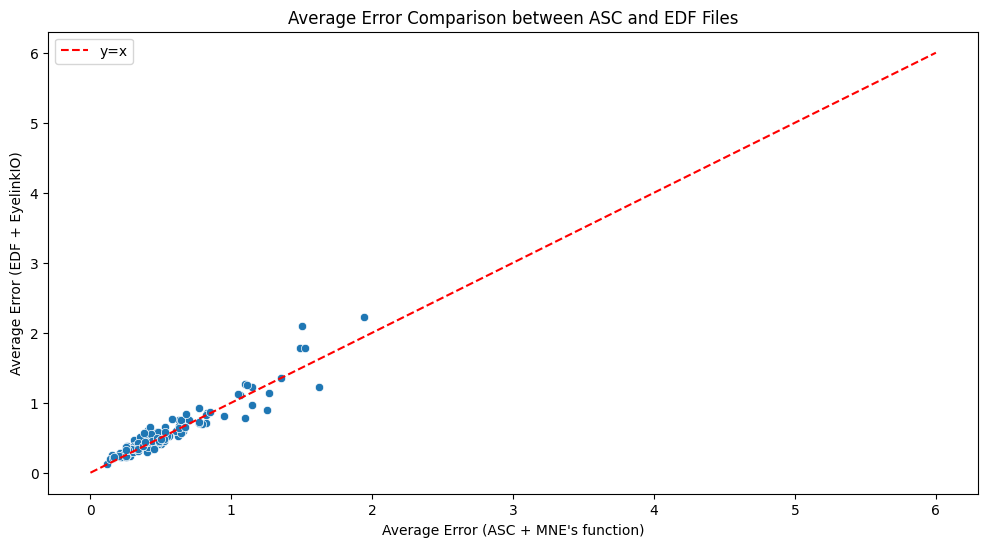

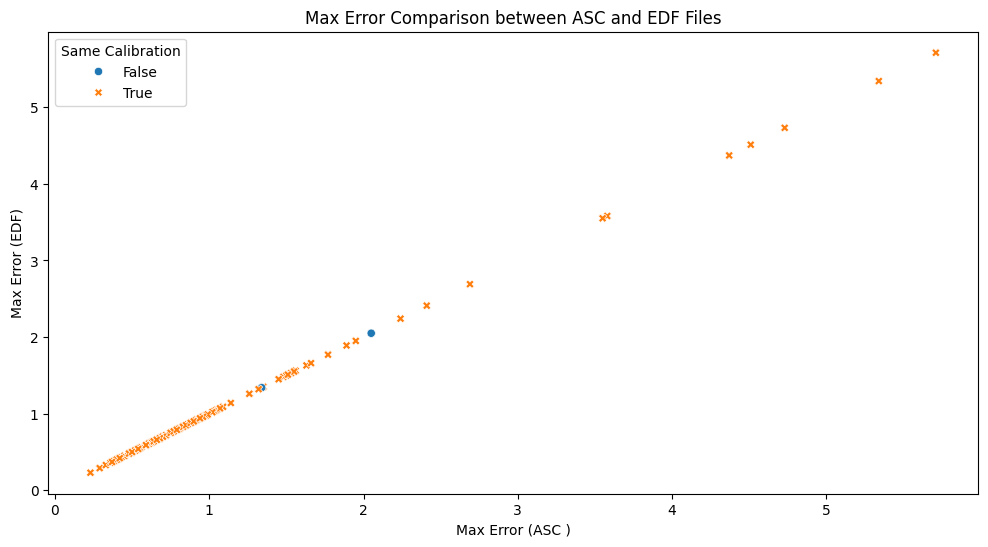

In [222]:
if run_test:
    # Merge with the calibration_df_asc and then compare the two dataframes if they are the same 
    calibration_df_merged = pd.merge(calibration_df_asc, calibration_df_edf, on="subject", suffixes=("_asc", "_edf"))
    # Check if the two dataframes are the same
    calibration_df_merged["same_calibration"] = (
        (calibration_df_merged["calibration_quality_asc"] == calibration_df_merged["calibration_quality_edf"])
    )


    # Remove subject with average error higher than 6
    calibration_df_merged = calibration_df_merged[calibration_df_merged["max_error_asc"] < 6]
    # Plot average error and max error for both asc and edf files
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=calibration_df_merged, x="avg_error_asc", y="avg_error_edf")
    plt.title("Average Error Comparison between ASC and EDF Files")
    plt.xlabel("Average Error (ASC + MNE's function)")
    plt.ylabel("Average Error (EDF + EyelinkIO)")
    plt.legend(title="Same Calibration")
    # Plot diagnonal line for both plots
    x = np.linspace(0, 6, 100)
    plt.plot(x, x, color='red', linestyle='--', label='y=x')
    plt.legend()

    # Plot largest max error for both asc and edf files
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=calibration_df_merged, x="max_error_asc", y="max_error_edf", hue="same_calibration", style="same_calibration")
    plt.title("Max Error Comparison between ASC and EDF Files")
    plt.xlabel("Max Error (ASC )")
    plt.ylabel("Max Error (EDF)")
    plt.legend(title="Same Calibration")
    # Show legend
    plt.legend(title="Same Calibration")
    # Show the plot
    plt.show()



else: 
    print("Skipping ASC calibration processing test.")

In [225]:
calibration_df_merged

,subject,n_calibrations_asc,avg_error_asc,max_error_asc,calibration_quality_asc,last_avg_error,last_max_error,n_calibrations_edf,avg_error_edf,max_error_edf,calibration_quality_edf,trimmed_mean,same_calibration
0,0042P,1,0.28,0.42,good,NaN,NaN,1,0.278,0.42,good,NaN,True
1,0043F1,1,0.36,0.97,good,NaN,NaN,1,0.420,0.97,good,NaN,True
2,0050M1,1,0.39,0.92,good,NaN,NaN,1,0.512,0.92,good,NaN,True
3,0050P,2,0.77,1.09,good,NaN,NaN,2,0.712,1.09,good,NaN,True
4,0062P,1,0.33,0.53,good,NaN,NaN,1,0.372,0.53,good,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1143P,1,0.68,1.66,fair,NaN,NaN,1,0.840,1.66,fair,0.790000,True
145,1147F1,1,0.37,0.42,good,NaN,NaN,1,0.376,0.42,good,0.383333,True
146,1147P,1,1.52,5.71,poor,NaN,NaN,1,1.788,5.71,poor,0.916667,True
147,1147S1,1,0.39,0.59,good,NaN,NaN,1,0.432,0.59,good,0.446667,True


## Check quick fix with trimmed means

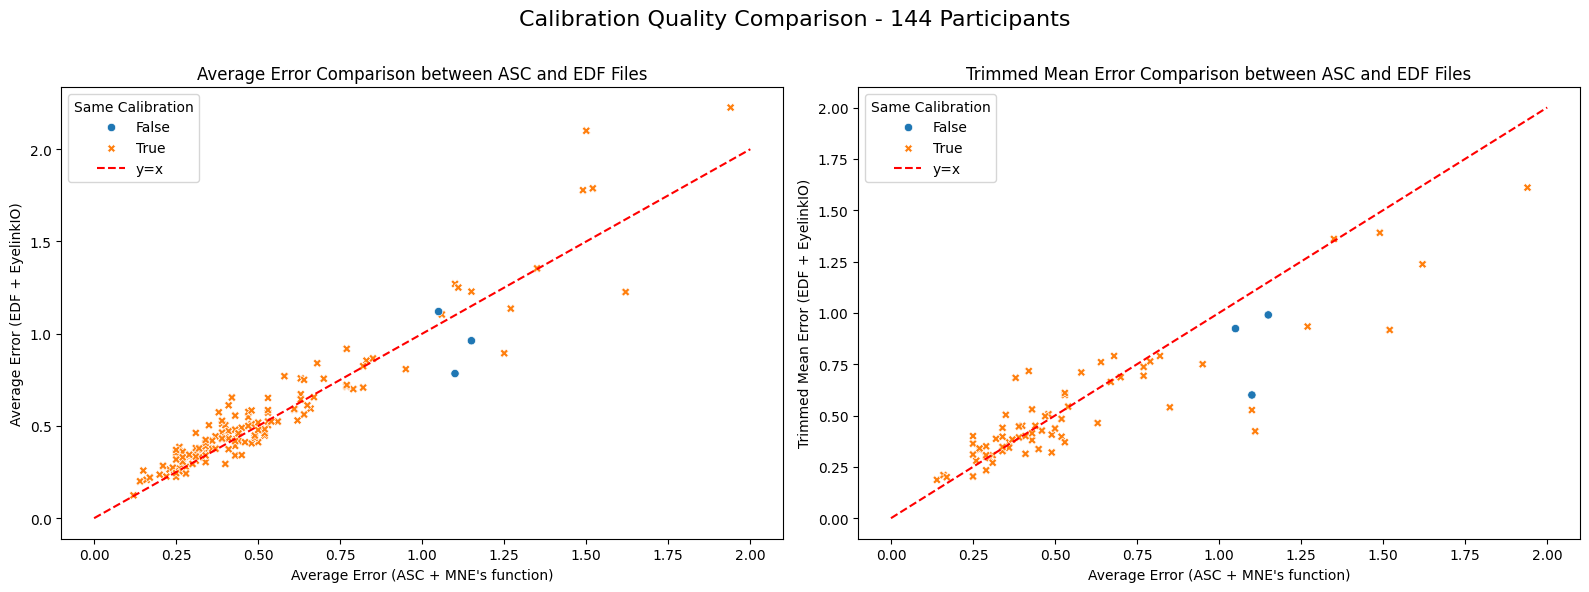

In [234]:
# Plot graphs with regular averages on the left and those with trimmed means on the right

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Plot average error comparison
sns.scatterplot(data=calibration_df_merged, x="avg_error_asc", y="avg_error_edf", ax=axes[0], hue="same_calibration", style="same_calibration")
axes[0].set_title("Average Error Comparison between ASC and EDF Files")
axes[0].set_xlabel("Average Error (ASC + MNE's function)")
axes[0].set_ylabel("Average Error (EDF + EyelinkIO)")
# Plot diagnonal line for both plots, but make it only maximum 1 after the last point

x = np.linspace(0, 2, 100)
axes[0].plot(x, x, color='red', linestyle='--', label='y=x')
axes[0].legend(title="Same Calibration")
# Plot average error with trimmed means
sns.scatterplot(data=calibration_df_merged, x="avg_error_asc", y="trimmed_mean", ax=axes[1], hue="same_calibration", style="same_calibration")

axes[1].set_title("Trimmed Mean Error Comparison between ASC and EDF Files")
axes[1].set_xlabel("Average Error (ASC + MNE's function)")
axes[1].set_ylabel("Trimmed Mean Error (EDF + EyelinkIO)")
# Plot diagnonal line for both plots
axes[1].plot(x, x, color='red', linestyle='--', label='y=x')
axes[1].legend(title="Same Calibration")
plt.tight_layout()

# Add n participants to the title
plt.suptitle(f"Calibration Quality Comparison - {len(calibration_df_merged)} Participants", fontsize=16)
plt.subplots_adjust(top=0.85)  # Adjust top to make room for the title
plt.show()

Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1078F1_GO.asc
Creating RawArray with float64 data, n_channels=3, n_times=65931
    Range : 0 ... 65930 =      0.000 ...   131.860 secs
Ready.
Calibration for subject 1078F1 using mne's read_eyelink_calibration:
Calibration |
  onset: -13.966 seconds
  model: HV5
  eye: left
  average error: 1.15 degrees
  max error: 1.34 degrees
  screen size: None meters
  screen distance: None meters
  screen resolution: None pixels

Trimmed mean for subject 1078F1: 0.9899999999999999
Calibration for subject 1078F1 using eyelink's read_edf().to_mne()
Calibration |
  onset: 0.0 seconds
  model: HV5
  eye: left
  average error: 0.962 degrees
  max error: 1.34 degrees
  screen size: None meters
  screen distance: None meters
  screen resolution: [1920 1080] pixels

Offsets for ASC file using mne's read_eyelink_calibration: [1.34 0.64 1.16 0.5  1.17]
Offsets for EDF file 

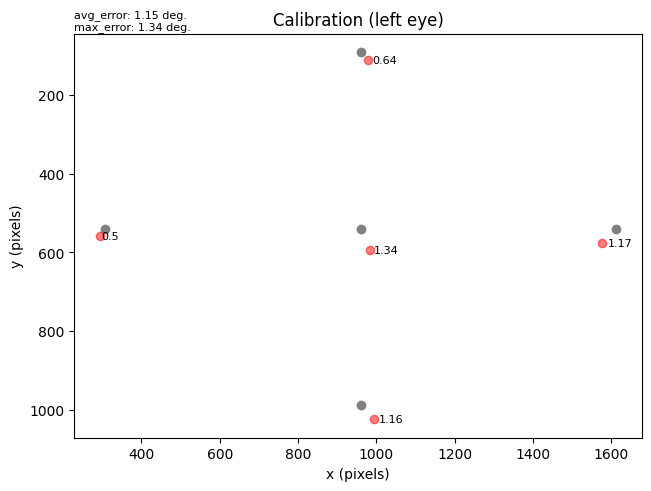

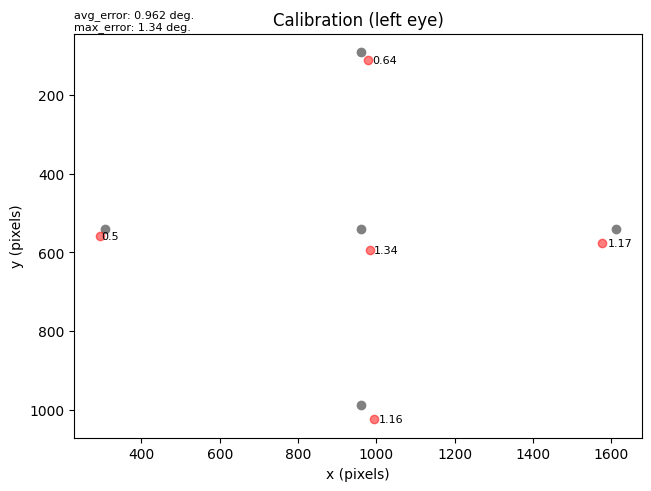

In [235]:
if run_test:
    # Check a data from two subjects

    # Get asc and edf files for subject 0043F1
    subject_id = "1078F1"
    asc_file = f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files/asc_files/{subject_id}_GO.asc"
    edf_file = f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files/edf_files/{subject_id}_GO.edf"
    # Read the asc file
    try:
        asc_cal = read_eyelink_calibration(asc_file)
    except Exception as e:
        print(f"Error reading asc file for subject {subject_id}: {e}")
        asc_cal = None
    # Read the edf file
    try:
        edf_data = read_edf(edf_file)
        edf_cal = edf_data.to_mne()[1]  # Get the calibration data
    except Exception as e:
        print(f"Error reading edf file for subject {subject_id}: {e}")
        edf_cal = None
    # Print the calibration data
    if asc_cal is not None:
        print(f"Calibration for subject {subject_id} using mne's read_eyelink_calibration:")
        print(asc_cal[-1])  # Print the last calibration
        
        # Print the trimmed mean
        print(f"Trimmed mean for subject {subject_id}: {stats.trim_mean(asc_cal[-1]['offsets'], 0.25)}")
        
    if edf_cal is not None:
        print(f"Calibration for subject {subject_id} using eyelink's read_edf().to_mne()")
        print(edf_cal[-1])  # Print the last calibration
        
    # Extract the offsets and plot the calibration data
    if asc_cal is not None:
        offsets_asc = asc_cal[-1]["offsets"]
        print(f"Offsets for ASC file using mne's read_eyelink_calibration: {offsets_asc}")
    if edf_cal is not None:
        offsets_edf = edf_cal[-1]["offsets"]
        print(f"Offsets for EDF file using read_edf().to_mne(): {offsets_edf}")
    # Plot the calibration data for both asc and edf files
    if asc_cal is not None:
        fig_asc = asc_cal[-1].plot()
        fig_asc.suptitle(f"Calibration for subject {subject_id} - Using Asc file and mne's read_eyelink_calibration", fontsize=16)
        plt.show()
    if edf_cal is not None:
        fig_edf = edf_cal[-1].plot()
        fig_edf.suptitle(f"Calibration for subject {subject_id} - Using EDF file and read_edf().to_mne()", fontsize=16)
        # Add subtitle as text 
        plt.show()
    